# Обучение с учителем: качество модели

**Постановка задачи.** 
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Заказчик** этого проекта:

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования.

**Исходные данные**, предоставляемые для реализации проекта, содержат данные о поведении и времени покупателя на сайте, а также данные о выручке и его продуктовом поведении.

## Общая информация о данных

### Импорт данных

Импорт необходимых библиотек

In [1]:
# установка библиотек 
!pip install matplotlib==3.3.4 -q
!pip install scikit-learn==1.2.0 -q
!pip install shap==0.43.0 -q
!pip install phik==0.12.4 -q

# импорт библиотеки pandas
import pandas as pd
# импорт библиотеки numpy
import numpy as np
# импорт библиотеки seaborn
import seaborn as sns
# импорт библиотеки shap
import shap

import warnings
warnings.filterwarnings('ignore')

# импорт модуля pyplot из библиотеки matplotlib
from matplotlib import pyplot as plt
# импорт модуля для корреляционного анализа
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder, 
    OrdinalEncoder,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# константы для обучения моделей
RANDOM_STATE = 42
TEST_SIZE = 0.25


Со стороны заказчика были предоставлены 4 датасета с исходной информацией о покупателях и их активности.

- Файл `market_file.csv` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;
- Файл `market_money.csv` с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом;
- Файл `market_time.csv` с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода;
- Файл `money.csv` с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

Напишем функцию для загрузки данных из файлов и отображения первичной информации о структуре данных.

In [2]:
def load_df(file_name, sep=',', decimal='.'):
    try:
        df = pd.read_csv('/datasets/' + file_name + '.csv', sep=sep, decimal=decimal)
    except:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/' + file_name + '.csv', sep=sep, decimal=decimal)
    
    print('Первые 5 строк загруженного датасета ', file_name)
    display(df.head())
    print('Последние 5 строк загруженного датасета ', file_name)
    display(df.tail())
    print('\nСтруктура данных загруженного датасета ', file_name)
    print(df.info())
    df_num_str = df.shape[0]
    print('\nКоличество строк датасета', file_name, ' до предобработки: ', df_num_str)
    print('\nОбщее количество пропущенных значений в загруженном датасете ', file_name)
    print(df.isna().sum().sort_values(ascending=False))
    print('\nКоличество строк с полными дубликатами датасета ', file_name, ' :', df.duplicated().sum())
    
    return df, df_num_str
        

 Функция вывода уникальных значений всех категориальных переменных 

In [10]:
def check_category(df):
    category_columns = df.select_dtypes(include='object').columns.tolist()
    for col in category_columns:
        print('\nУникальные значения столца ', col)
        print('Количество: ', df[col].nunique())
        print('Значения: ', df[col].unique())
    return category_columns

Функция комбинации методов обработки строк

In [12]:
def str_change(df, column, w_replace='', t_replace=''):
    return (df[column]
                  .str.lower()
                  .str.replace(w_replace, t_replace, regex=True)
                 )

### Описание и структура данных

#### Датасет `market_file`

##### Общая информация о структуре данных `market_file`

In [3]:
df_market_file, df_market_file_old_size = load_df('market_file') 

Первые 5 строк загруженного датасета  market_file


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Последние 5 строк загруженного датасета  market_file


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7
1299,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,5,3,12



Структура данных загруженного датасета  market_file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 n

Файл `market_file.csv` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

Датасет состоит из `13` столбцов и `1300` строк. 

По всем столбцам, кроме `Покупательская активность`, `Тип сервиса`, `Разрешить сообщать` и `Популярная категория` данные хранятся в числовом формате. 

Пропусков значений в строках по всем столбцам не обнаружено, как и строк с явными полными дубликатами. 
<br><br>
Ниже содержится описание столбцов с указанием типа данных:
- `id` — номер покупателя в корпоративной базе данных, тип данных: `целочисленный`.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень», тип данных: `строковый`.
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт», тип данных: `строковый`.
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре (согласие на это даёт покупатель), тип данных: `строковый`.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев (это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента), тип данных: `числа с плавающей точкой`.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце, тип данных: `целочисленный`.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте, тип данных: `целочисленный`.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев, тип данных: `числа с плавающей точкой`.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев, тип данных: `строковый`.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца, тип данных: `целочисленный`.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца, тип данных: `целочисленный`.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта, тип данных: `целочисленный`.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, тип данных: `целочисленный`.

На первый взгляд значения стобцов в датасете соответствуют их типам и не требуют преобразований. 

In [4]:
df_market_file.columns.to_list()

['id',
 'Покупательская активность',
 'Тип сервиса',
 'Разрешить сообщать',
 'Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Популярная_категория',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит']

#### Датасет `market_money`

##### Общая информация о структуре данных `market_money`

In [5]:
df_market_money, df_market_money_old_size = load_df('market_money') 

Первые 5 строк загруженного датасета  market_money


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Последние 5 строк загруженного датасета  market_money


,id,Период,Выручка
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0
3899,216647,текущий_месяц,4448.3



Структура данных загруженного датасета  market_money
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None

Количество строк датасета market_money  до предобработки:  3900

Общее количество пропущенных значений в загруженном датасете  market_money
id         0
Период     0
Выручка    0
dtype: int64

Количество строк с полными дубликатами датасета  market_money  : 0


Файл `market_money.csv` содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

Датасет состоит из `3` столбцов и `3900` строк. 

Пропусков значений в строках по всем столбцам не обнаружено, как и строк с явными полными дубликатами. 
<br><br>
Ниже содержится описание столбцов с указанием типа данных:
- `id` — номер покупателя в корпоративной базе данных, тип данных: `целочисленный`.
- `Период` — название периода, во время которого зафиксирована выручка (например, 'текущий_месяц' или 'предыдущий_месяц'), тип данных: `строковый`.
- `Выручка` — сумма выручки за период, тип данных: `числа с плавающей точкой`.

На первый взгляд значения стобцов в датасете соответствуют их типам и не требуют преобразований. 

#### Датасет `market_time`

##### Общая информация о структуре данных `market_time`

In [6]:
df_market_time, df_market_time_old_size = load_df('market_time') 

Первые 5 строк загруженного датасета  market_time


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Последние 5 строк загруженного датасета  market_time


,id,Период,минут
2595,216645,текущий_месяц,18
2596,216646,предыдцщий_месяц,18
2597,216646,текущий_месяц,7
2598,216647,текущий_месяц,10
2599,216647,предыдцщий_месяц,15



Структура данных загруженного датасета  market_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None

Количество строк датасета market_time  до предобработки:  2600

Общее количество пропущенных значений в загруженном датасете  market_time
id        0
Период    0
минут     0
dtype: int64

Количество строк с полными дубликатами датасета  market_time  : 0


Файл `market_time.csv` содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.

Датасет состоит из `3` столбцов и `2600` строк. 

Пропусков значений в строках по всем столбцам не обнаружено, как и строк с полными явными дубликатами. 
<br><br>
Ниже содержится описание столбцов с указанием типа данных:
- `id` — номер покупателя в корпоративной базе данных, тип данных: `целочисленный`.
- `Период` — название периода, во время которого зафиксировано общее время, тип данных: `строковый`.
- `минут` — значение времени, проведённого на сайте, в минутах, тип данных: `целочисленный`.

На первый взгляд значения стобцов в датасете соответствуют их типам и не требуют преобразований. 

#### Датасет `money`

##### Общая информация о структуре данных `money`

In [7]:
df_money, df_money_old_size = load_df('money', sep=';', decimal=',') 

Первые 5 строк загруженного датасета  money


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Последние 5 строк загруженного датасета  money


,id,Прибыль
1295,216643,4.44
1296,216644,6.11
1297,216645,3.29
1298,216646,4.03
1299,216647,3.28



Структура данных загруженного датасета  money
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None

Количество строк датасета money  до предобработки:  1300

Общее количество пропущенных значений в загруженном датасете  money
id         0
Прибыль    0
dtype: int64

Количество строк с полными дубликатами датасета  money  : 0


Файл `money.csv` содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

Датасет состоит из `2` столбцов и `1300` строк. 

Пропусков значений в строках по всем столбцам не обнаружено, как и строк с полными явными дубликатами. 
<br><br>
Ниже содержится описание столбцов с указанием типа данных:
- `id` — номер покупателя в корпоративной базе данных, тип данных: `целочисленный`.
- `Прибыль` — значение прибыли, тип данных: `числа с плавающей точкой`.

На первый взгляд значения стобцов в датасете соответствуют их типам и не требуют преобразований. 

### Итоги анализа информации о данных

На текущем шаге выполнены следующие задачи:
- произведен [импорт](#Импорт-данных) данных из файлов `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv`, датасеты сохранены в соответствующие датафреймы `df_market_file`, `df_market_money`, `df_market_time`, `df_money`; 
- для каждого датафрейма [`df_market_file`](#Датасет-market_file), [`df_market_money`](#Датасет-market_money), [`df_market_time`](#Датасет-market_time), [`df_money`](#Датасет-money) выведены характеристики:
    - первые 5 строк;
    - последние 5 строк;
    - структура данных датасета;
    - число строк и столбцов;
    - тип данных столбцов;
    - количество пропущеных значений;
    - количество дубликатов;
- первичный анализ данных по всем датасетам не выявил наличия пропусков и явных полных дубликатов, а также необходимости производить переводы данных в другие типы. 

##  Предобработка данных

### Предобработка датасета `df_market_file`

#### Приведение наименований столбцов к общему формату

Произведем переименование столбцов датасета `df_market_file`

In [8]:
df_market_file = df_market_file.rename(columns={
    'Покупательская активность':'customer_activity',
    'Тип сервиса':'service_type',
    'Разрешить сообщать':'allow_to_inform',
    'Маркет_актив_6_мес': 'market_active_half_year',
    'Маркет_актив_тек_мес': 'market_active_month',
    'Длительность': 'duration',
    'Акционные_покупки': 'promo_purchases_ratio',
    'Популярная_категория': 'popular_category',
    'Средний_просмотр_категорий_за_визит': 'avg_check_category',
    'Неоплаченные_продукты_штук_квартал': 'unpaid_products_unit_quater',
    'Ошибка_сервиса': 'service_error',
    'Страниц_за_визит': 'pages_visited'
})
df_market_file.columns.to_list()

['id',
 'customer_activity',
 'service_type',
 'allow_to_inform',
 'market_active_half_year',
 'market_active_month',
 'duration',
 'promo_purchases_ratio',
 'popular_category',
 'avg_check_category',
 'unpaid_products_unit_quater',
 'service_error',
 'pages_visited']

Столбцы успешно переименованы.

#### Анализ типов данных

Исходя из информации о датасете, полученной в пункте [1.2.1.1](#Общая-информация-о-структуре-данных-market_file), в исследуемом датасете отсутствуют пропуски значений, а типы данных соответствуют своему содержимому, поэтому преобразование типов не требуется.


#### Анализ явных дубликатов

На этапе получения информации о данных в пункте [1.2.1.1](#Общая-информация-о-структуре-данных-market_file) не было обнаружено полных явных дубликатов.

Поиск явных дубликатов на этом для датасета `df_market_file` может быть завершен, поскольку повторы значений в остальных столбцах могут встречаться, главное, чтобы не было повторов в столбце `id`, что и проверим

In [9]:
df_market_file.duplicated(subset='id').sum()

0

#### Анализ неявных дубликатов

Для анализа неявных дубликатов используем функцию вывода уникальных значений всех категориальных переменных 

In [11]:
category_columns_market_file = check_category(df_market_file)


Уникальные значения столца  customer_activity
Количество:  2
Значения:  ['Снизилась' 'Прежний уровень']

Уникальные значения столца  service_type
Количество:  3
Значения:  ['премиум' 'стандартт' 'стандарт']

Уникальные значения столца  allow_to_inform
Количество:  2
Значения:  ['да' 'нет']

Уникальные значения столца  popular_category
Количество:  6
Значения:  ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


В столбце `service_type` присутствует неявный дубликат для значения `стандарт`. Приведем значения к нижнему регистру и устраним его с помощью комбинации методов обработки строк, реализованных в функции `str_change`. Также приведем значения к нижнему регистру для остальных столбцов

In [13]:
for col in category_columns_market_file:
    if col != 'service_type':
        df_market_file[col] = str_change(df_market_file, col)
    else:
        df_market_file[col] = str_change(df_market_file, col, 'стандартт', 'стандарт')

Проверим результаты наших преобразований

In [14]:
category_columns_market_file = check_category(df_market_file)


Уникальные значения столца  customer_activity
Количество:  2
Значения:  ['снизилась' 'прежний уровень']

Уникальные значения столца  service_type
Количество:  2
Значения:  ['премиум' 'стандарт']

Уникальные значения столца  allow_to_inform
Количество:  2
Значения:  ['да' 'нет']

Уникальные значения столца  popular_category
Количество:  6
Значения:  ['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']


Еще раз проверим датасет на полные явные дубликаты

In [15]:
df_market_file.duplicated().sum()

0

На этом предобработка данных текущего датасета может быть завершена

### Предобработка датасета `df_market_money`

#### Приведение наименований столбцов к общему формату

Произведем переименование столбцов датасета `df_market_money`

In [16]:
df_market_money = df_market_money.rename(columns={
    'Период':'period_money',
    'Выручка':'revenue'
})
df_market_money.columns.to_list()

['id', 'period_money', 'revenue']

Столбцы успешно переименованы.

#### Анализ типов данных

Исходя из информации о датасете, полученной в пункте [1.2.1.2](#Общая-информация-о-структуре-данных-market_money), в исследуемом датасете отсутствуют пропуски значений, а типы данных соответствуют своему содержимому, поэтому преобразование типов не требуется.


#### Анализ явных дубликатов

На этапе получения информации о данных в пункте [1.2.1.1](#Общая-информация-о-структуре-данных-market_money) не было обнаружено полных явных дубликатов.

Поиск явных дубликатов на этом для датасета `df_market_file` может быть завершен, поскольку повторы значений в остальных столбцах могут встречаться, в том числе и в столбце `id`, т.к. данные по каждому пользователю собраны за 3 месяца, а пользователей `1300`, судя по количеству значений в датасете `df_market_file`

In [17]:
df_market_money.duplicated(subset='id').sum()

2600

#### Анализ неявных дубликатов

Воспользуемся ранее написанной функций для просмотра уникальных значений в столбцах в категориальными переменными

In [18]:
category_columns_market_money = check_category(df_market_money)


Уникальные значения столца  period_money
Количество:  3
Значения:  ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


Неявных дубликатов нет, но приведем значения у более удобной форме записи и исправим опечатки

In [19]:
df_market_money['period_money'] = str_change(df_market_money, 'period_money', '_', ' ')
df_market_money['period_money'] = str_change(df_market_money, 'period_money', 'препредыдущий месяц', 'позапрошлый месяц')

Проверим результаты наших преобразований

In [20]:
category_columns_market_money = check_category(df_market_money)


Уникальные значения столца  period_money
Количество:  3
Значения:  ['позапрошлый месяц' 'текущий месяц' 'предыдущий месяц']


На этом предобработка данных текущего датасета может быть завершена

### Предобработка датасета `df_market_time`

#### Приведение наименований столбцов к общему формату

Произведем переименование столбцов датасета `df_market_time`

In [21]:
df_market_time = df_market_time.rename(columns={
    'Период':'period_time',
    'минут':'minutes'
})
df_market_time.columns.to_list()

['id', 'period_time', 'minutes']

Столбцы успешно переименованы.

#### Анализ типов данных

Исходя из информации о датасете, полученной в пункте [1.2.1.3](#Общая-информация-о-структуре-данных-market_time), в исследуемом датасете отсутствуют пропуски значений, а типы данных соответствуют своему содержимому, поэтому преобразование типов не требуется.


#### Анализ явных дубликатов

На этапе получения информации о данных в пункте [1.2.1.3](#Общая-информация-о-структуре-данных-market_file) не было обнаружено полных явных дубликатов.

Поиск явных дубликатов на этом для датасета `df_market_time` может быть завершен, поскольку повторы значений в остальных столбцах могут встречаться, в том числе и в столбце `id`, т.к. данные по каждому пользователю собраны не за 1 месяц, а пользователей `1300`, судя по количеству значений в датасете `df_market_file`

In [22]:
df_market_time.duplicated(subset='id').sum()

1300

#### Анализ неявных дубликатов

Воспользуемся ранее написанной функций для просмотра уникальных значений в столбцах в категориальными переменными

In [23]:
category_columns_market_time = check_category(df_market_time)


Уникальные значения столца  period_time
Количество:  2
Значения:  ['текущий_месяц' 'предыдцщий_месяц']


Неявных дубликатов нет, но приведем значения у более удобной форме записи и исправим опечатку в наименовании периода 

In [24]:
df_market_time['period_time'] = str_change(df_market_time, 'period_time', '_', ' ')
df_market_time['period_time'] = str_change(df_market_time, 'period_time', 'предыдцщий', 'предыдущий')

Проверим результаты наших преобразований

In [25]:
category_columns_market_time = check_category(df_market_time)


Уникальные значения столца  period_time
Количество:  2
Значения:  ['текущий месяц' 'предыдущий месяц']


На этом предобработка данных текущего датасета может быть завершена

### Предобработка датасета `df_money`

#### Приведение наименований столбцов к общему формату

Произведем переименование столбцов датасета `df_money`

In [26]:
df_money = df_money.rename(columns={
    'Прибыль':'profit'
})
df_money.columns.to_list()

['id', 'profit']

Столбцы успешно переименованы.

#### Анализ типов данных

Исходя из информации о датасете, полученной в пункте [1.2.1.4](#Общая-информация-о-структуре-данных-money), в исследуемом датасете отсутствуют пропуски значений, а типы данных соответствуют своему содержимому, поэтому преобразование типов не требуется.


#### Анализ явных дубликатов

На этапе получения информации о данных в пункте [1.2.1.4](#Общая-информация-о-структуре-данных-money) не было обнаружено полных явных дубликатов.

Поиск явных дубликатов на этом для датасета `df_money` может быть завершен, поскольку повторы значений в остальных столбцах могут встречаться, кроме столбца `id`, что и проверим:

In [27]:
df_money.duplicated(subset='id').sum()

0

#### Анализ неявных дубликатов

Поскольку в этом датасете отсутствуют столбцы с категориальными переменными, поиск неявных дубликатов производится не будет

На этом предобработка данных текущего датасета может быть завершена

### Итоги предобработки данных

На текущем шаге выполнены следующие задачи: 
- для всех датафремов:
    - не обнаружено пропусков значений в столбцах и полных явных дубликатов;
    - определено, что значения в столбцах соответствуют их типу;
    - произведено переименование столбцов;
- для датафрейма [`df_market_file`](#Предобработка-датасета-df_market_file) также:
    - устранены неявные дубликаты в столбцах с категориальными значениями, значения приведены к единому формату.
- для датафрейма [`df_market_money`](#Предобработка-датасета-df_market_money) также:
    - обнаружены явные дубликаты в столбце `id`, что соответствует наличию данных за несколько месяцев;
    - неявных дубликатов в столбцах с категориальными значениями не обнаружено, значения приведены к единому формату.
- для датафрейма [`df_market_time`](#Предобработка-датасета-df_market_time) также:
    - обнаружены явные дубликаты в столбце `id`, что соответствует наличию данных за несколько месяцев;
    - неявных дубликатов в столбцах с категориальными значениями не обнаружено, исправлена опечатка в наименовании периода, а значения приведены к единому формату.
- для датафрейма [`df_money`](#Предобработка-датасета-df_money) также:
    - явные дубликаты в столбце `id` не обнаружены;
    - поиск неявных дубликатов не производился, поскольку отсутствуют столбцы с категориальными значениями.

## Исследовательский анализ данных

Создадим словарь перевода наименования показателей `column_translate` для отрисовки на графиках

In [28]:
# наименования колонок для отображения на графиках
column_translate = {
    'id':'id',
    'customer_activity':'Покупательская активность',
    'service_type':'Тип сервиса',
    'allow_to_inform':'Разрешить сообщать',
    'market_active_half_year':'Маркет. актив-ть за 6 месяцев',
    'market_active_month':'Маркет. актив-ть в текущем месяце',
    'duration':'Длительность',
    'promo_purchases_ratio':'Доля акционных покупок',
    'popular_category':'Популярная категория',
    'avg_check_category':'Среднее кол-во просмотров категорий за визит',
    'unpaid_products_unit_quater':'Неоплаченные продукты, шт./квартал',
    'service_error':'Ошибка сервиса',
    'pages_visited':'Кол-во страниц за визит', 
    'period_money':'Период',
    'revenue':'Выручка',
    'period_time':'Период',
    'minutes':'Время на сайте, мин.',
    'profit':'Прибыль'
}

# цветовая палитра
colors_map = sns.color_palette("Set2", 8)

Для отрисовки распределения количественных показателей создадим функцию вывода гистограмм и диаграммы размаха по указанному столбцу `plot_hist_box` 

In [29]:
def plot_hist_box(df, column, bins_num):
    plt.figure(figsize=(10, 8))
    histplot_range = plt.hist(df[column], bins=bins_num)
    plt.subplot(2, 1, 1)
    plt.suptitle("Распределение значений по показателю " + column_translate[column], fontsize=12)
    df[column].plot(kind='hist', color=colors_map, grid=True, bins=bins_num)
    plt.vlines(x=df[column].mean(), colors='red', ymin=histplot_range[0].min(), ymax=histplot_range[0].max(), label='Среднее')
    plt.vlines(x=df[column].median(), colors='red', ymin=histplot_range[0].min(), ymax=histplot_range[0].max(), linestyles='--', label='Медиана')
    plt.xlabel(column_translate[column], fontsize=10)
    plt.ylabel("количество", fontsize=10)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    df[column].plot(kind='box', grid=True, vert=False)
    plt.xlabel(column_translate[column], fontsize=10)
    plt.show()

Для отрисовки распределения категориальных показателей создадим функцию вывода гистограммы и круговой диаграммы по указанному столбцу `plot_bar_pie`

In [30]:
def plot_bar_pie(df, column):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.suptitle("Распределение значений по показателю " + column_translate[column], fontsize=12)
    df[column].value_counts().plot(kind='bar', color=colors_map, grid=True)
    plt.xlabel(column_translate[column], fontsize=10)
    plt.ylabel("количество", fontsize=10)
    
    plt.subplot(1, 2, 2)
    df[column].value_counts().plot(kind='pie', autopct='%1.2f%%', wedgeprops=dict(width=0.75), colors=colors_map, legend=True)
    plt.ylabel(column_translate[column], fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 0))
    plt.show()

### Исследовательский анализ датасета `df_market_file`

#### Анализ количественных признаков датасета `df_market_file`

Определим столбцы с количественными значениями

In [31]:
num_columns_market_file = df_market_file.select_dtypes(exclude='object').columns.tolist()
num_columns_market_file

['id',
 'market_active_half_year',
 'market_active_month',
 'duration',
 'promo_purchases_ratio',
 'avg_check_category',
 'unpaid_products_unit_quater',
 'service_error',
 'pages_visited']

Среди количественных признаков мы можем выделить данные в столбцах:
- `market_active_half_year`
- `market_active_month`
- `duration`
- `promo_purchases_ratio`
- `avg_check_category`
- `unpaid_products_unit_quater`
- `service_error`
- `pages_visited`

Значения в столбце `id` не относятся к количественным признакам, поскольку отображают уникальный идентификатор пользователей. 

In [32]:
num_columns_market_file.remove('id')

##### Статистические характеристики

Выведем статистические характеристики для всех столбцов, содержащих количественные значения

In [33]:
df_market_file[num_columns_market_file].describe().T

,count,mean,std,min,25%,50%,75%,max
market_active_half_year,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.9,6.60
market_active_month,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.0,5.00
duration,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.0,1079.00
promo_purchases_ratio,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.3,0.99
avg_check_category,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.0,6.00
unpaid_products_unit_quater,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.0,10.00
service_error,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.0,9.00
pages_visited,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.0,20.00


На первый взгляд значения практически во всех столбцах не вызывают подозрений о наличии выбросов, поскольку средние и медианные характеристики близки по значению, а стандартное отклонение небольшое, кроме столбца `duration`. 

Рассмотрим подробнее распределение значений по каждому из столбцов. 

##### Анализ столбца `market_active_half_year`

Построим график распределения значений в этом столбце

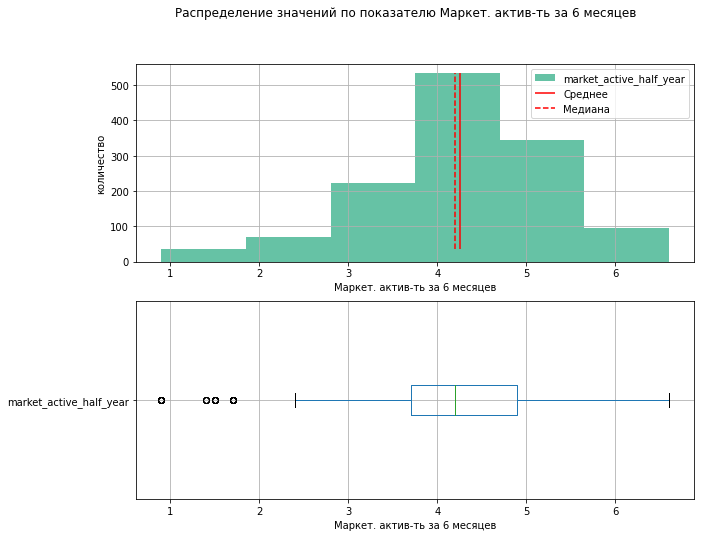

In [34]:
plot_hist_box(df_market_file, num_columns_market_file[0], 6)

Распределение данных близко к нормальному, присутствуют незначительные выбросы, но данные расположены компактно.

Большая часть значений этого столбца находится в отрезке `[3.7;4.9]`, что соответствует 1-му и 3-му квантилям. 


##### Анализ столбца `market_active_month`

Значения в этом столбце отображают количество маркетинговых коммуникаций за текущий месяц и относятся к дискретным величинам, поэтому для анализа распределения построим столбчатую и круговую диаграммы

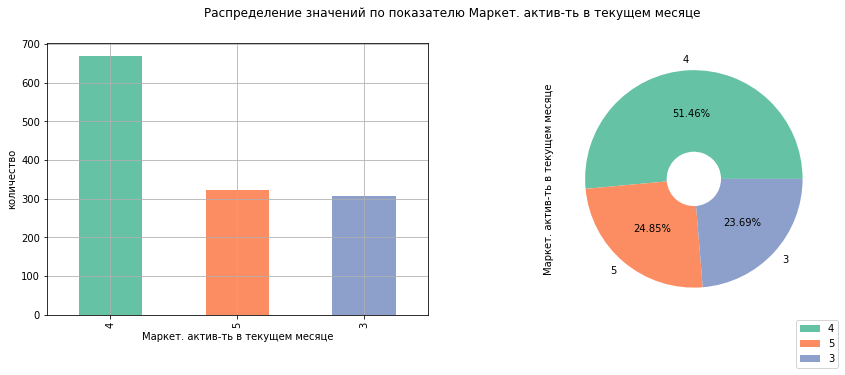

In [35]:
plot_bar_pie(df_market_file, num_columns_market_file[1])

Большая часть значений по этому столбцу `51.46%` приходится на значение `4`, на втором месте значение `5` с долей `24.85%`.

##### Анализ столбца `duration`

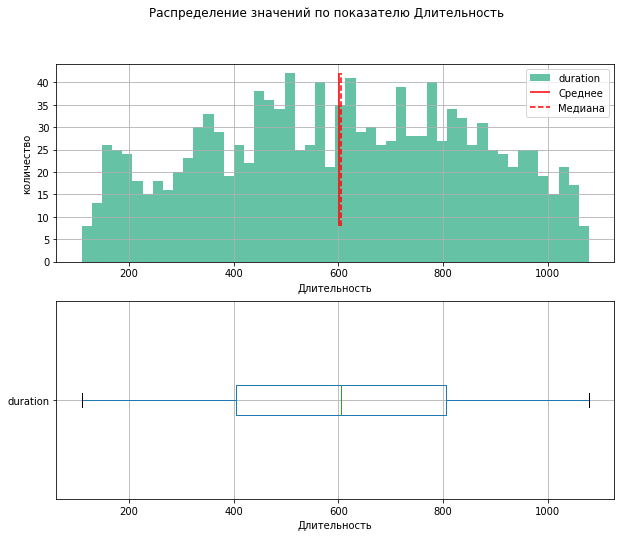

In [36]:
plot_hist_box(df_market_file, num_columns_market_file[2], 50)

Данные в этом столбце распределены близко к нормальному в промежутке `[110.00;1079.00]`, границы которого соответствуют минимальному и максимальному значению. 

Выбросов не обнаружено.

Основная доля значений сосредоточена в промежутке `[405.50;806.00]`, границы которого соответствуют значениям 1-го и 3-го квантилей. 

Медианное значение составляет `606.00`, среднее `601.90`. 

##### Анализ столбца `promo_purchases_ratio`

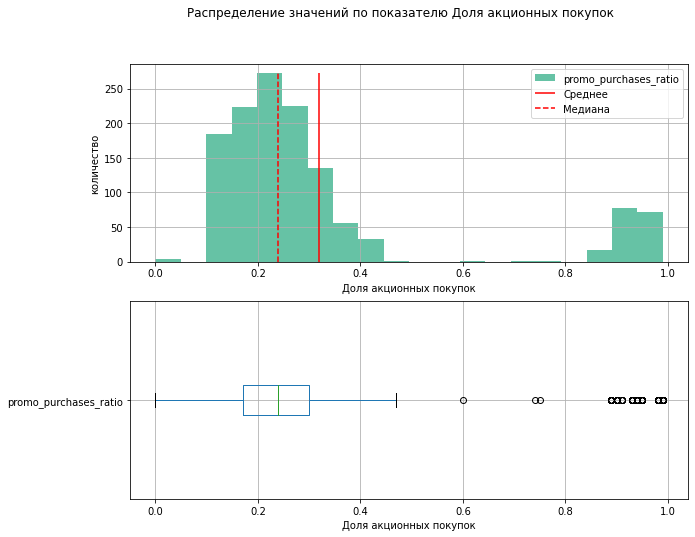

In [37]:
plot_hist_box(df_market_file, num_columns_market_file[3], 20)

Данные в этом столбце распределены близко к бимодальному в промежутке `[0.00;0.99]`, границы которого соответствуют минимальному и максимальному значению. 

Присутствуют незначительные выбросы.

Основная доля значений сосредоточена в промежутке `[0.17;0.30]`, границы которого соответствуют значениям 1-го и 3-го квантилей. 

Медианное значение составляет `0.24`, среднее `0.32`. 

##### Анализ столбца `avg_check_category`

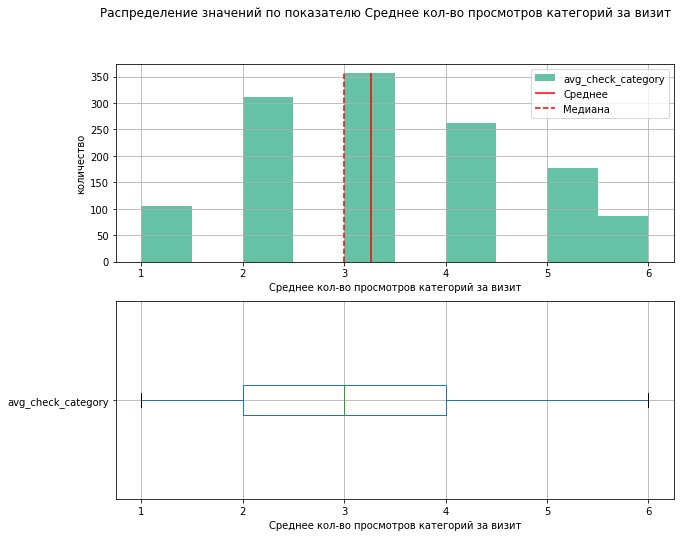

In [38]:
plot_hist_box(df_market_file, num_columns_market_file[4], 10)

Судя по графикам, данные этого столбца распределены близко к нормальному и не содержат выбросов, но значения в этом столбце отображают среднее количество просмотров категорий за визит и относятся к дискретным величинам, поэтому для анализа распределения построим столбчатую и круговую диаграммы

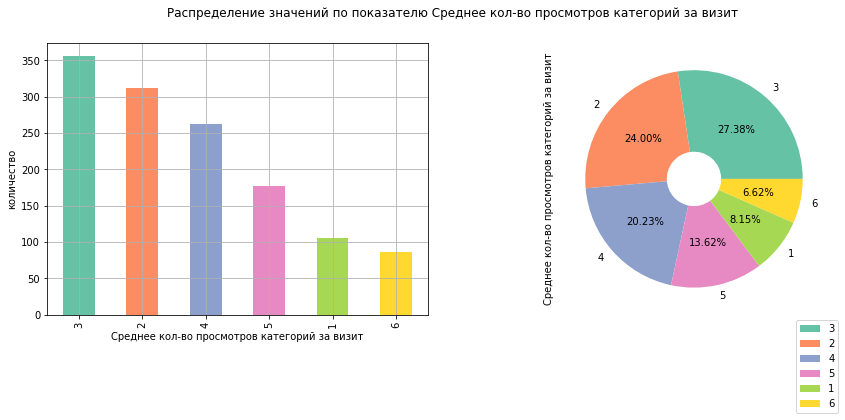

In [39]:
plot_bar_pie(df_market_file, num_columns_market_file[4])

Большая часть значений по этому столбцу `27.38%` приходится на значение `3`, на втором месте значение `2` с долей `24.00%`. Меньшую долю `6.62%` занимает значение `6`.

##### Анализ столбца `unpaid_products_unit_quater`

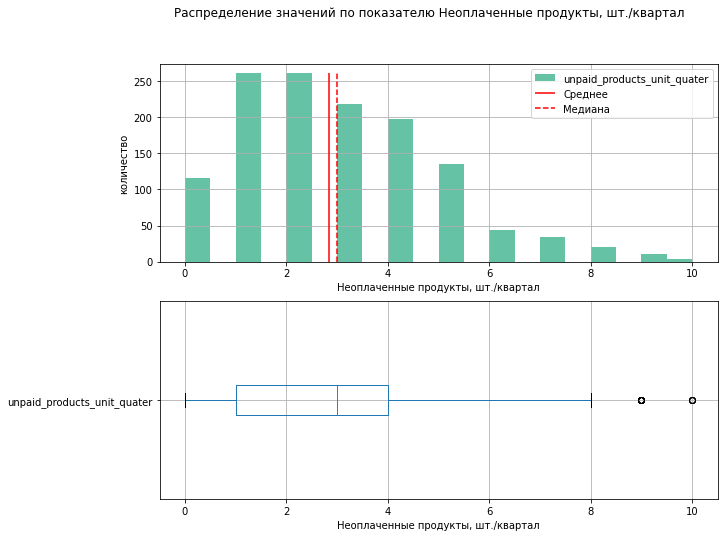

In [40]:
plot_hist_box(df_market_file, num_columns_market_file[5], 20)

Судя по графикам, данные этого столбца распределены близко к нормальному со смещением влево и содержат незначительные выбросы, но значения в этом столбце отображают количество неоплаченных продуктов за квартал и относятся к дискретным величинам, поэтому для анализа распределения построим столбчатую и круговую диаграммы

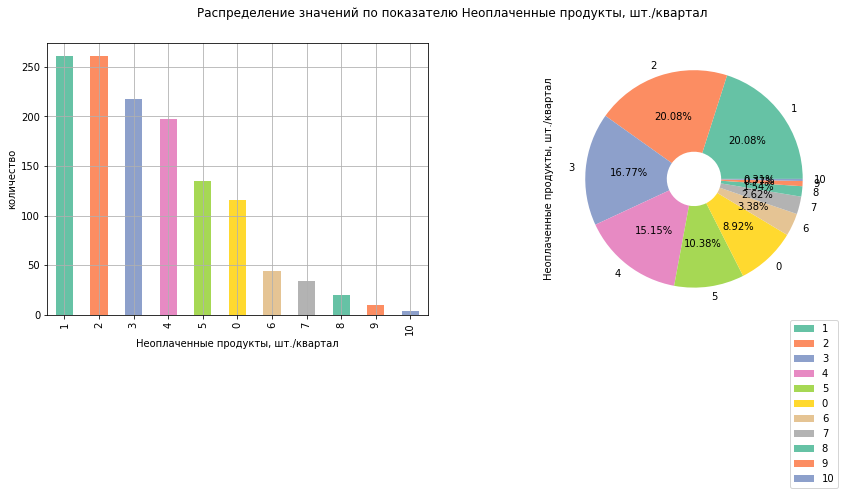

In [41]:
plot_bar_pie(df_market_file, num_columns_market_file[5])

Большая часть значений по этому столбцу `20.08%` приходится на значения `1` и `2`, на втором месте значение `3` с долей `16.77%`. Меньше всего записей со значениями `9` и `10`.

##### Анализ столбца `service_error`

Значения в этом столбце отображают количество ошибок сервиса и относятся к дискретным величинам, поэтому для анализа распределения построим столбчатую и круговую диаграммы

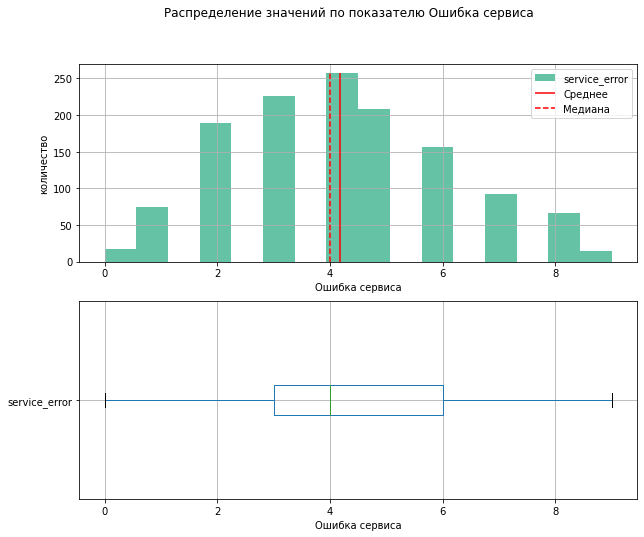

In [42]:
plot_hist_box(df_market_file, num_columns_market_file[6], 16)

Судя по графикам, данные этого столбца распределены близко к нормальному и не содержат выбросов, но значения в этом столбце отображают количество ошибок сервиса и относятся к дискретным величинам, поэтому для анализа распределения построим столбчатую и круговую диаграммы

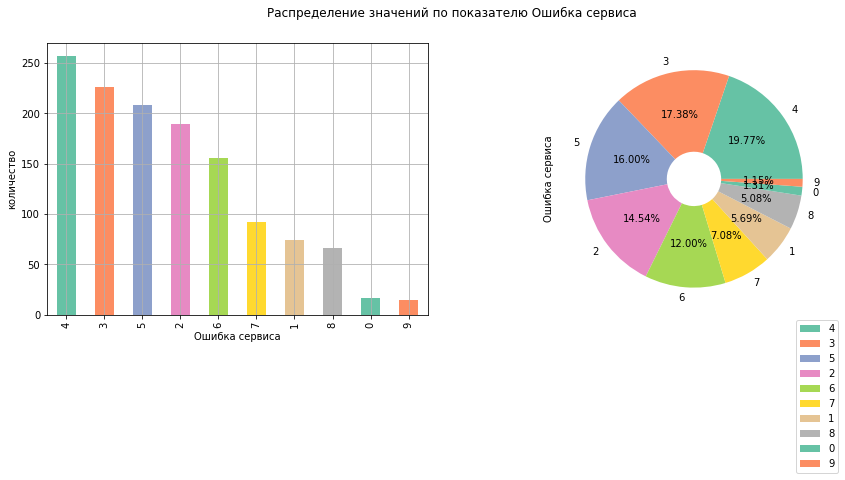

In [43]:
plot_bar_pie(df_market_file, num_columns_market_file[6])

Большая часть значений по этому столбцу `19.77%` приходится на значение `4`, на втором месте значение `3` с долей `17.38%`. Меньше всего записей со значениями `9` и `0`.

##### Анализ столбца `pages_visited`

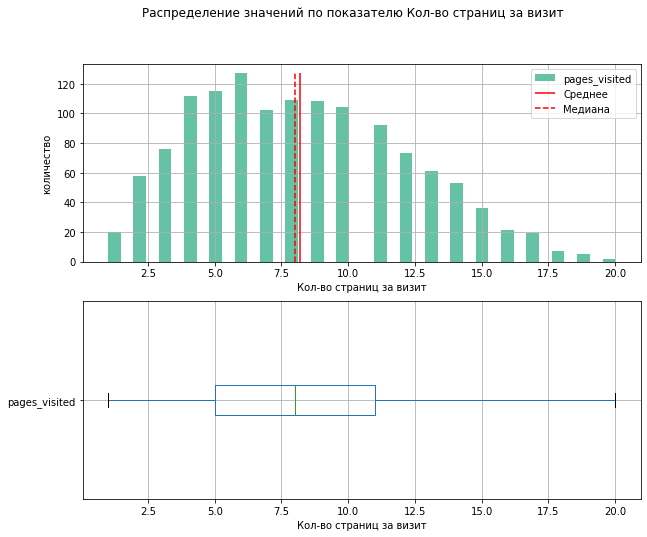

In [44]:
plot_hist_box(df_market_file, num_columns_market_file[7], 40)

Судя по графикам, данные этого столбца распределены близко к нормальному и не содержат выбросов, но значения в этом столбце отображают количество страниц за визит и относятся к дискретным величинам, поэтому для анализа распределения построим столбчатую и круговую диаграммы

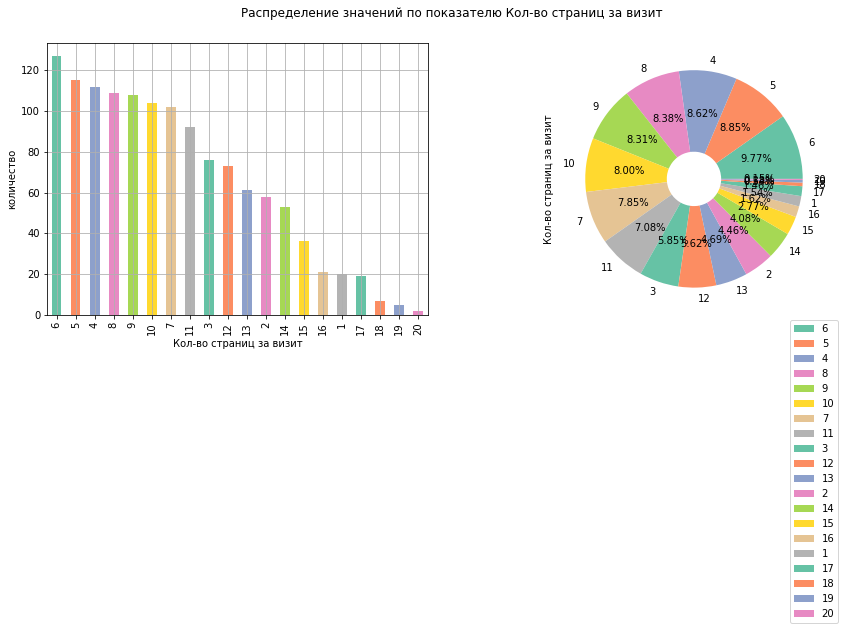

In [45]:
plot_bar_pie(df_market_file, num_columns_market_file[7])

Большая часть значений по этому столбцу `9.77%` приходится на значение `6`, на втором месте значение `5` с долей `8.85%`. Меньше всего записей со значениями `19` и `20`.

#### Анализ категориальных признаков датасета `market_file`

In [46]:
category_columns_market_file

['customer_activity', 'service_type', 'allow_to_inform', 'popular_category']

Среди категориальных признаков мы можем выделить данные в столбцах:
- `id`
- `customer_activity`
- `service_type`
- `allow_to_inform` 
- `popular_category`

Выведем количество уникальных значений в каждом столбце, кроме `id`, поскольку значения этого столбца соответствуют уникальному идентификатору пользователей. 

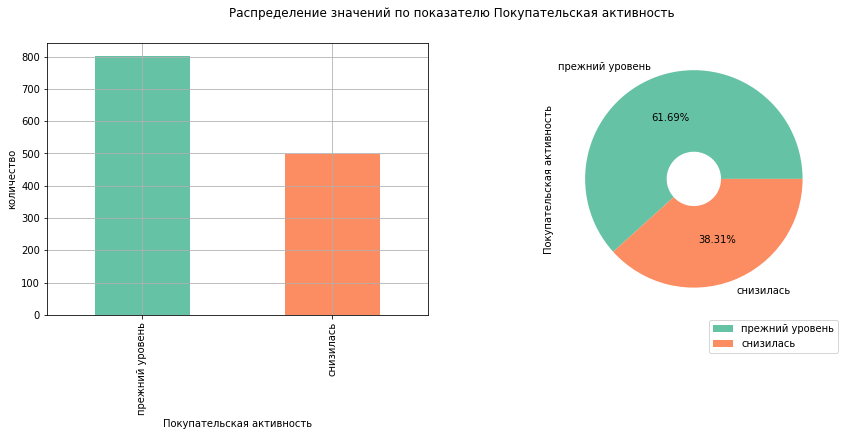

In [47]:
plot_bar_pie(df_market_file, category_columns_market_file[0])

Доля покупателей со значением активности `прежний уровень` в датасете составляет `61.69%`, остальные покупатели относятся к категории активности `снизилась`.

Этот показатель является целевым, и мы можем заметить, что присутствует небольшой дисбаланс классов. Следует учесть это при формировании выборок для обучения и тестирования моделей.

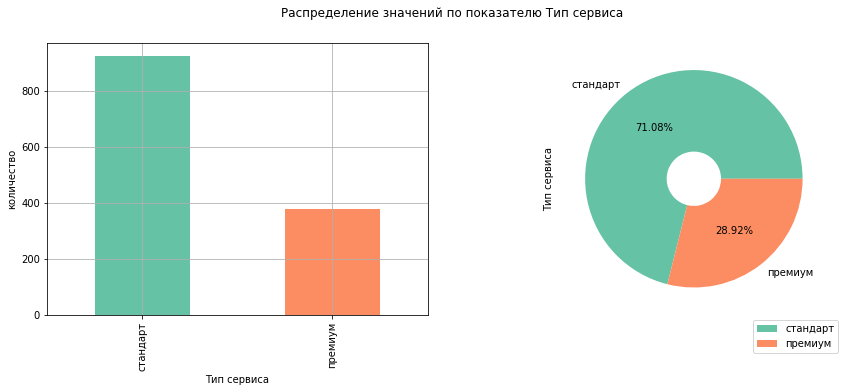

In [48]:
plot_bar_pie(df_market_file, category_columns_market_file[1])

Доля покупателей со значением типа сервиса `стандарт` в датасете составляет `71.08%`, остальные покупатели относятся к категории типа сервиса `премиум`.

Возможно эта информация нам понадобится при анализе результатов, поскольку выручка от категории покупателей `премиум` может значительно отличаться от сумм стандартной категории.

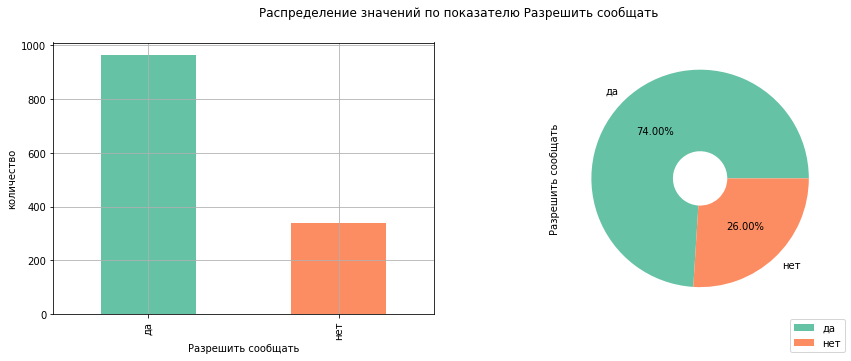

In [49]:
plot_bar_pie(df_market_file, category_columns_market_file[2])

Доля покупателей, которые разрешили подтвердили участие в маркетинговых коммуникациях, составляет `74.00%`, остальные покупатели не дали согласие на отправку маркетинговых предложений. 

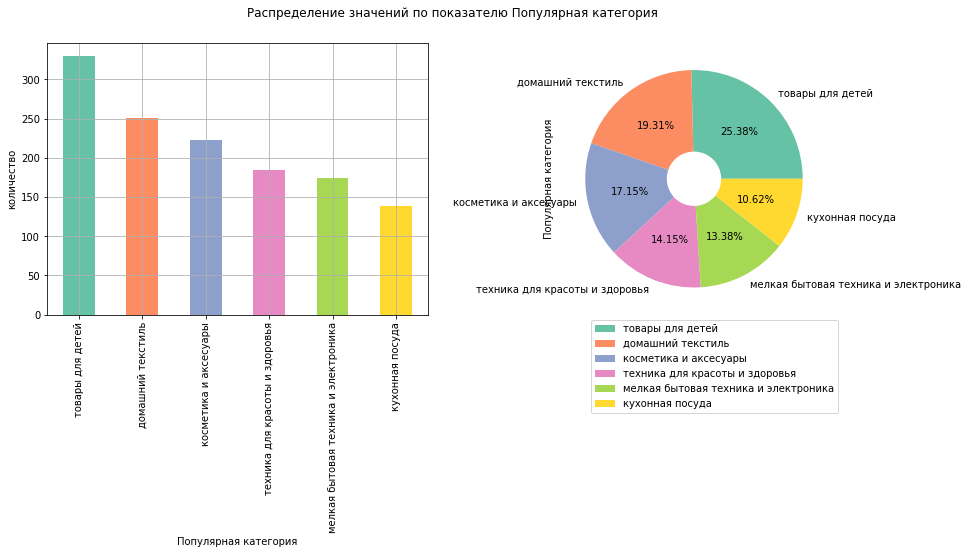

In [50]:
plot_bar_pie(df_market_file, category_columns_market_file[3])

Самая популярная категория товаров среди покупателей `товары для детей`, доля записей составляет `25.38%`. Меньше всего покупатели отдают предпочтение категории `кухонная посуда`, доля составляет `10.62%`.

### Исследовательский анализ датасета `df_market_money`

#### Анализ количественных признаков датасета `df_market_money`

Определим столбцы с количественными значениями

In [51]:
num_columns_market_money = df_market_money.select_dtypes(exclude='object').columns.tolist()
num_columns_market_money

['id', 'revenue']

Среди количественных признаков мы можем выделить данные в столбцах:
- `revenue`

Значения в столбце `id` не относятся к количественным признакам, поскольку отображают уникальный идентификатор пользователей. Анализ по этому столбцу производить не будем.

In [52]:
num_columns_market_money.remove('id')

##### Статистические характеристики

Выведем статистические характеристики для всех столбцов, содержащих количественные значения

In [53]:
df_market_money[num_columns_market_money].describe().T

,count,mean,std,min,25%,50%,75%,max
revenue,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.0,106862.2


Величина стандартного отклонения, а также существенная разница между средним и медианным значением говорят о наличии выбросов по этому показателю.

Рассмотрим подробнее распределение значений на графиках.

##### Анализ столбца `revenue`

Построим график распределения значений в этом столбце

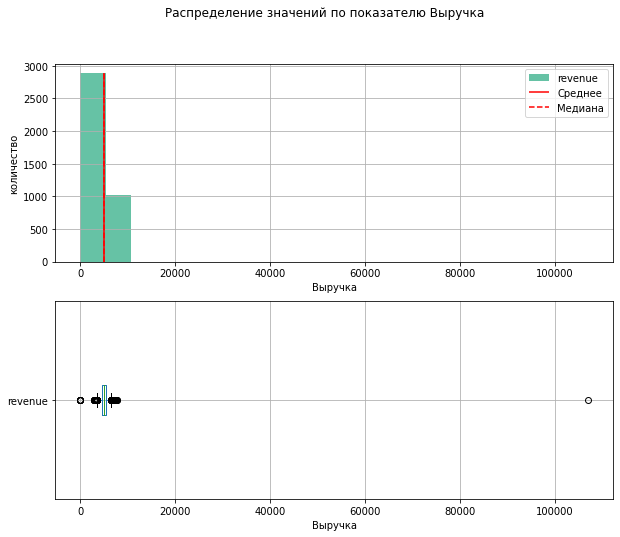

In [54]:
plot_hist_box(df_market_money, num_columns_market_money[0], 20)

График распределения подтверждает наше предположение о наличии выбросов. 

Большая часть значений этого столбца находится в отрезке `[4590.15;5363.00]`, что соответствует 1-му и 3-му квантилям. 

Посмотрим на строки датасета, где значение в этом столбце превышает `20000`.

In [55]:
df_market_money.query("revenue > 20000")

,id,period_money,revenue
98,215380,текущий месяц,106862.2


Обнаружена одна строка с выбивающимися значениями, что составляет `0.03%` от общего числа строк датасета. Удалим эту строку и внесем `id` в список для удаления в остальных датасетах, данные по этому покупателю мы рассматривать не будем.  

In [56]:
print('{:.2%}'.format(df_market_money.query('revenue > 20000')['id'].count() / df_market_money_old_size))

0.03%


In [57]:
id_to_delete = df_market_money[df_market_money['revenue'] > 20000]['id'].to_list()
id_to_delete

[215380]

In [58]:
df_market_money = df_market_money.query("revenue <= 20000")
df_market_money.shape[0]

3899

Также на графике можно заметить выброс в области `0`, посмотрим на строки с таким значением

In [59]:
df_market_money.query("revenue <= 1")

,id,period_money,revenue
0,215348,позапрошлый месяц,0.0
2,215348,предыдущий месяц,0.0
28,215357,позапрошлый месяц,0.0
29,215357,предыдущий месяц,0.0
34,215359,предыдущий месяц,0.0
35,215359,позапрошлый месяц,0.0


Обнаружено `6` строк с выбивающимися значениями по трем покупателям, что составляет `0.15%` от общего числа строк датасета. По факту покупательская активность у таких пользователей отсутствует за рассматриваемый период, но именно такие покупатели и должны войти в число тех, кому бы следовало направить маркетинговое предложение, поэтому строки с такими значениями мы удалять не будем.  

In [60]:
print('{:.2%}'.format(df_market_money.query('revenue <= 1')['id'].count() / df_market_money_old_size))

0.15%


Посмотрим на текущие статистические характеристики после удаления выбивающихся значений.

In [61]:
df_market_money[num_columns_market_money].describe().T

,count,mean,std,min,25%,50%,75%,max
revenue,3899.0,4999.57743,706.99988,0.0,4590.1,4957.0,5363.0,7799.4


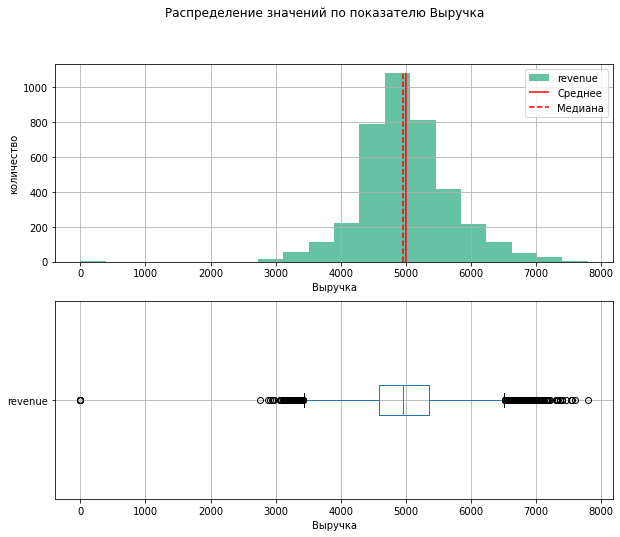

In [62]:
plot_hist_box(df_market_money, num_columns_market_money[0], 20)

Данные в этом столбце распределены близко к нормальному, присутствуют выбросы, но данные расположены компактно. В целом, если удалить значения, близкие к 0, распределение было бы еще больше похоже на нормальное, а величина стандартного отклонения значительно снизилась, но перед нами не стоит такой задачи.

Основная доля значений сосредоточена в промежутке `[4590.10; 5363.00]`, границы которого соответствуют значениям 1-го и 3-го квантилей.

Медианное значение составляет `4957.00`, среднее `4999.58`. 

Обновим значения в датасетах, удалив записи о пользователях с выбивающимися значениями.

In [63]:
df_market_file = df_market_file.query('id not in @id_to_delete')
df_market_money = df_market_money.query('id not in @id_to_delete')
df_market_time = df_market_time.query('id not in @id_to_delete')
df_money = df_money.query('id not in @id_to_delete')

#### Анализ категориальных признаков датасета `df_market_money`

In [64]:
category_columns_market_money

['period_money']

Среди категориальных признаков мы можем выделить данные в столбцах:
- `id`
- `period_money`

Рассмотрим распределение значений в каждом столбце, кроме `id`, поскольку значения этого столбца соответствуют уникальному идентификатору пользователей. 

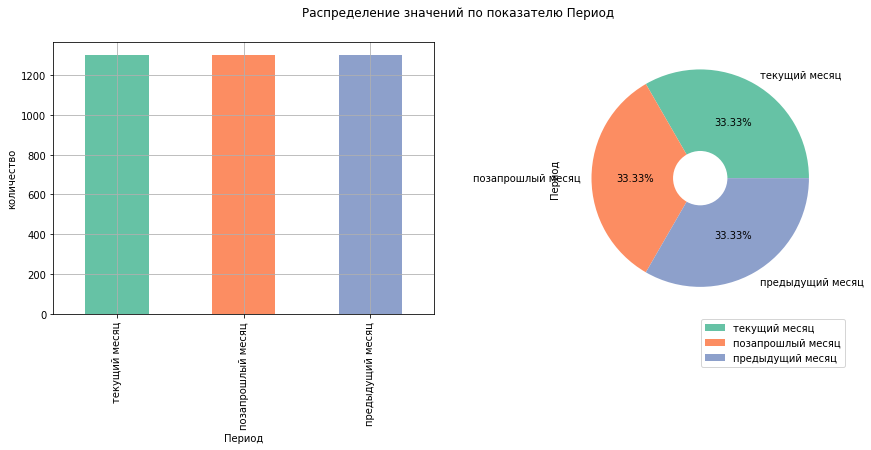

In [65]:
plot_bar_pie(df_market_money, category_columns_market_money[0])

Данные содержатся за три месяца и распределены в одинаковой пропорции по всем категориям периодов. 

### Исследовательский анализ датасета `df_market_time`

#### Анализ количественных признаков датасета `df_market_time`

Определим столбцы с количественными значениями

In [66]:
num_columns_market_time = df_market_time.select_dtypes(exclude='object').columns.tolist()
num_columns_market_time

['id', 'minutes']

Среди количественных признаков мы можем выделить данные в столбцах:
- `minutes`

Значения в столбце `id` не относятся к количественным признакам, поскольку отображают уникальный идентификатор пользователей. Анализ по этому столбцу производить не будем.

In [67]:
num_columns_market_time.remove('id')

##### Статистические характеристики

Выведем статистические характеристики для всех столбцов, содержащих количественные значения

In [68]:
df_market_time[num_columns_market_time].describe().T

,count,mean,std,min,25%,50%,75%,max
minutes,2598.0,13.336413,4.081664,4.0,10.0,13.0,16.0,23.0


На первый взгляд значения не вызывают подозрений о наличии выбросов, поскольку средние и медианные характеристики практически совпадают, а стандартное отклонение небольшое. 

Рассмотрим подробнее распределение значений на графиках. 

##### Анализ столбца `minutes`

Построим график распределения значений в этом столбце

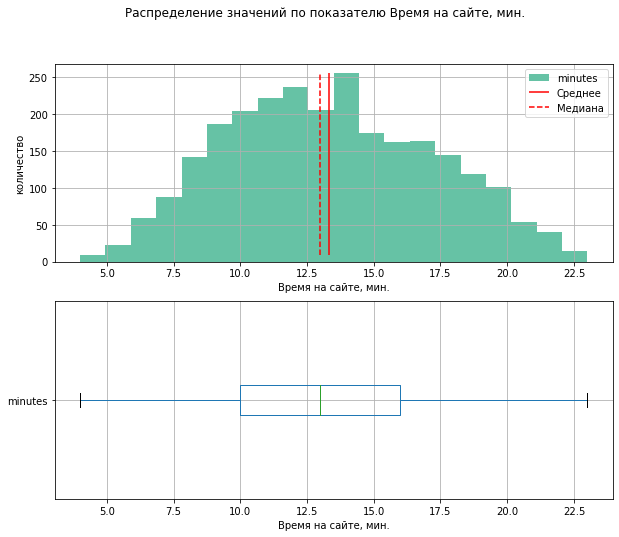

In [69]:
plot_hist_box(df_market_time, num_columns_market_time[0], 20)

График распределения подтверждает наше предположение близком к нормальному распределении значений в этом столбце, выбросы отсутствуют. 

Большая часть значений этого столбца находится в отрезке `[10.00;16.00]`, что соответствует 1-му и 3-му квантилям. 

#### Анализ категориальных признаков датасета `df_market_time`

In [70]:
category_columns_market_time

['period_time']

Среди категориальных признаков мы можем выделить данные в столбцах:
- `id`
- `period_time`

Рассмотрим распределение значений в каждом столбце, кроме `id`, поскольку значения этого столбца соответствуют уникальному идентификатору пользователей. 

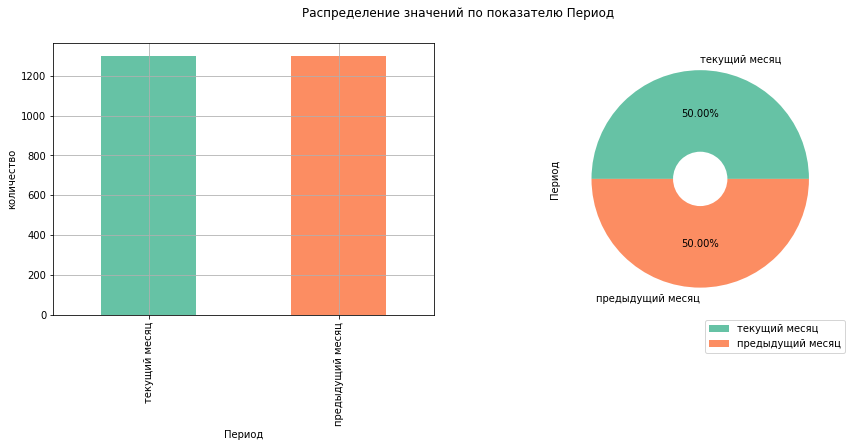

In [71]:
plot_bar_pie(df_market_time, category_columns_market_time[0])

Данные содержатся за два месяца и распределены в равных пропорциях.

### Исследовательский анализ датасета `df_money`

#### Анализ количественных признаков датасета `df_money`

Определим столбцы с количественными значениями

In [72]:
num_columns_money = df_money.select_dtypes(exclude='object').columns.tolist()
num_columns_money

['id', 'profit']

Среди количественных признаков мы можем выделить данные в столбцах:
- `profit`

Значения в столбце `id` не относятся к количественным признакам, поскольку отображают уникальный идентификатор пользователей. Анализ по этому столбцу производить не будем.

In [73]:
num_columns_money.remove('id')

##### Статистические характеристики

Выведем статистические характеристики для всех столбцов, содержащих количественные значения

In [74]:
df_money[num_columns_money].describe().T

,count,mean,std,min,25%,50%,75%,max
profit,1299.0,3.996721,1.014107,0.86,3.3,4.05,4.67,7.43


На первый взгляд значения не вызывают подозрений о наличии выбросов, поскольку средние и медианные характеристики практически совпадают, а стандартное отклонение небольшое. 

Рассмотрим подробнее распределение значений на графиках. 

##### Анализ столбца `profit`

Построим график распределения значений в этом столбце

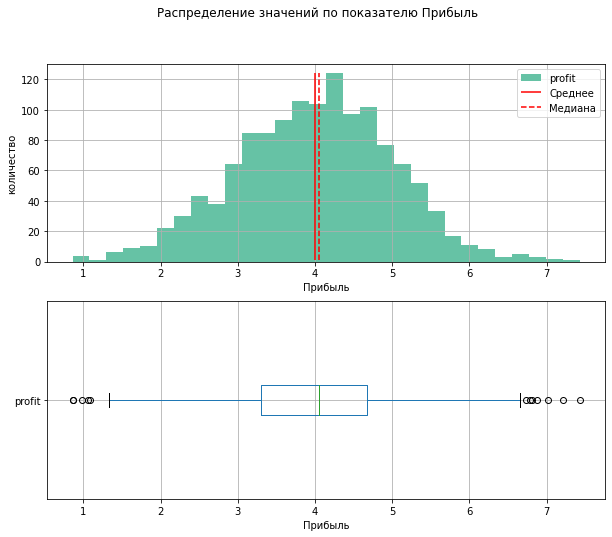

In [75]:
plot_hist_box(df_money, num_columns_money[0], 30)

Данные в этом столбце распределены близко к нормальному с небольшим смещением вправо в промежутке `[0.86;7.43]`, границы которого соответствуют минимальному и максимальному значению. 

Присутствуют незначительные выбросы.

Основная доля значений сосредоточена в промежутке `[3.30; 4.67]`, границы которого соответствуют значениям 1-го и 3-го квантилей. 

Медианное значение составляет `4.05`, среднее `4.00`. 

Проверим строки, содержащие выбросы по этому столбцу.

Доля строк, содержащих выбросы, составляет `1.77%` от общего числа строк исходного датасета. Данные из этого датасета не будут использованы при построении модели классификации, поэтому удалять такие строки не будем. 

In [76]:
print('{:.2%}'.format(df_money.query('profit <= 1.5 or profit >= 6.5')['id'].count() / df_money_old_size))

1.77%


### Итоги исследовательского анализа данных

На текущем шаге выполнены следующие задачи: 
- для датафрейма `df_market_file` произведены следующие этапы:
    - определены [количественные признаки](#Анализ-количественных-признаков-датасета-df_market_file):
        - выведены статистические характеристики для всех количественных признаков;
        - построены графики распределения значений для столбцов `market_active_half_year`, `market_active_month`, `duration`, `promo_purchases_ratio`, `avg_check_category`, `unpaid_products_unit_quater`, `service_error`, `pages_visited`;
        - большая часть показателей относится к дискретным величинам;
        - большая часть значений распределены близко к нормальному с незначительными либо отсутствующими выбросами;
        - по столбцу `promo_purchases_ratio` распределение близко к бимодальному;
    - определены [категориальные признаки](#Анализ-категориальных-признаков-датасета-df_market_file):
        - выведены графики распределения количества записей в датасете для столбцов `customer_activity`, `service_type`, `allow_to_inform`, `popular_category`.
        - выявлен небольшой дисбаланс классов по целевому показателю;
        - возможно потребуется отдельное рассмотрение покупателей, относящихся к категории сервиса `премиум`;
        - самая популярная категория товаров среди покупателей `товары для детей`, доля записей составляет `25.38%`. Меньше всего покупатели отдают предпочтение категории `кухонная посуда`, доля составляет `10.62%`.
      
- для датафрейма `df_market_money` произведены следующие этапы:
    - определены [количественные признаки](#Анализ-количественных-признаков-датасета-df_market_money):
        - выведены статистические характеристики для всех количественных признаков;
        - построены графики распределения значений для столбца `revenue`;
        - удалена строка с выбивающимся значением, после удаления распределение значений близко к нормальному с незначительными выбросами;
    - определены [категориальные признаки](#Анализ-категориальных-признаков-датасета-df_market_money):
        - выведены графики распределения количества записей в датасете для столбца `period_money`;
        - данные распределены в равных пропорциях по трем месяцам;
        
- для датафрейма `df_market_time` произведены следующие этапы:
    - определены [количественные признаки](#Анализ-количественных-признаков-датасета-df_market_time):
        - выведены статистические характеристики для всех количественных признаков;
        - построены графики распределения значений для столбца `minutes`;
        - данные распределены близко к нормальному, выбивающихся значений нет.
    - определены [категориальные признаки](#Анализ-категориальных-признаков-датасета-df_market_time):
        - выведены графики распределения количества записей в датасете для столбца `period_time`;
        - данные распределены в равных пропорциях по двум месяцам;
        
- для датафрейма `df_money` произведены следующие этапы:
    - определены [количественные признаки](#Анализ-количественных-признаков-датасета-df_market_time):
        - выведены статистические характеристики для всех количественных признаков;
        - построены графики распределения значений для столбца `profit`;
        - данные распределены близко к нормальному, есть незначительная доля выбивающихся значений.
    - категориальные признаки в датасете отсутствуют.

## Объединение таблиц

### Добавление столбцов по периодам

Перед объединением таблиц проведем преобразование датасетов `df_market_money` и `df_market_time` в сводные таблицы с добавления столбцов по периодам 

#### Датасет `df_market_money_new`

Создадим сводную таблицу по выручке для каждого периода в отдельном столбце

In [77]:
df_market_money_new = pd.pivot_table(df_market_money, index='id', columns='period_money', values='revenue')
df_market_money_new.columns = ['revenue_month-1', 'revenue_month-2', 'revenue_month']
df_market_money_new.head()

,revenue_month-1,revenue_month-2,revenue_month
id,,,
215348,0.0,0.0,3293.1
215349,4472.0,5216.0,4971.6
215350,4826.0,5457.5,5058.4
215351,4793.0,6158.0,6610.4
215352,4594.0,5807.5,5872.5


Проверим, есть ли среди покупателей те, у кого выручка хотя бы в одном из 3-х месяцев равна 0

In [78]:
df_market_money_new[(df_market_money_new['revenue_month-1'] == 0) 
                                    | (df_market_money_new['revenue_month-2'] == 0) 
                                    | (df_market_money_new['revenue_month'] == 0)]

,revenue_month-1,revenue_month-2,revenue_month
id,,,
215348,0.0,0.0,3293.1
215357,0.0,0.0,5986.3
215359,0.0,0.0,4735.0


Найдено три покупателя, чья выручка за 2 последних месяца равна 0, а в текущем месяце они совершали какие-то покупки. 
Мы исключим из рассмотрения таких покупателей, поскольку целевой признак подразумевает либо снижение покупательской активности, либо прежний уровень, а в этом случае уровень покупательской активности повысился. Следовательно, обучать модель на таких данных будет некорректно. 

In [79]:
df_market_money_new = df_market_money_new[(df_market_money_new['revenue_month-1'] != 0) 
                                    & (df_market_money_new['revenue_month-2'] != 0) 
                                    & (df_market_money_new['revenue_month'] != 0)]

Дополним словарь новыми наименованиями колонок

In [80]:
column_translate['revenue_month-1'] = 'Выручка за предыдущий месяц'
column_translate['revenue_month-2'] = 'Выручка за предпредыдущий месяц'
column_translate['revenue_month'] = 'Выручка за текущий месяц'

#### Датасет `df_market_time_new`

Создадим сводную таблицу по времени для каждого периода в отдельном столбце

In [81]:
df_market_time_new = pd.pivot_table(df_market_time, index='id', columns='period_time', values='minutes')
df_market_time_new.columns = ['minutes_month-1', 'minutes_month']
df_market_time_new.head()

,minutes_month-1,minutes_month
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


Дополним словарь новыми наименованиями колонок

In [82]:
column_translate['minutes_month-1'] = 'Время за предыдущий месяц, мин.'
column_translate['minutes_month'] = 'Время за текущий месяц, мин.'

### Преобразование индексов

Установим столбец `id` в качестве индекса для остальных датасетов 

In [83]:
df_market_file = df_market_file.set_index('id')
df_market_file.head()

,customer_activity,service_type,allow_to_inform,market_active_half_year,market_active_month,duration,promo_purchases_ratio,popular_category,avg_check_category,unpaid_products_unit_quater,service_error,pages_visited
id,,,,,,,,,,,,
215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5
215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2


In [84]:
df_money = df_money.set_index('id')
df_money.head()

,profit
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21


### Объединение датасетов 

Произведем объединение датасетов `df_market_file`, `df_market_time_new` и `df_market_money_new` по `id` с помощью метода `merge` со значением параметра `how='inner'`

In [85]:
df_market = df_market_file.merge(df_market_money_new, on='id', how='inner').merge(df_market_time_new, on='id', how='inner')
df_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_activity            1296 non-null   object 
 1   service_type                 1296 non-null   object 
 2   allow_to_inform              1296 non-null   object 
 3   market_active_half_year      1296 non-null   float64
 4   market_active_month          1296 non-null   int64  
 5   duration                     1296 non-null   int64  
 6   promo_purchases_ratio        1296 non-null   float64
 7   popular_category             1296 non-null   object 
 8   avg_check_category           1296 non-null   int64  
 9   unpaid_products_unit_quater  1296 non-null   int64  
 10  service_error                1296 non-null   int64  
 11  pages_visited                1296 non-null   int64  
 12  revenue_month-1              1296 non-null   float64
 13  revenue_mon

Количество полученных строк совпадает с необходимым количеством `id`, т.к. ранее мы удалили только одного пользователя из рассмотрения во всех датасетах и еще трех пользователей на этапе проверки выручки. Пропуски значений по всем столбцам отсутствуют

### Итоги объединения данных

В ходе исследования на текущем шаге были выполнены следующие задачи:
- добавлены отдельные столбцы по периодам для [выручки](#Датасет-df_market_money_new) и [времени на сайте](#Датасет-df_market_time_new), данные собраны в отдельные сводные таблицы `df_market_money_new` и `df_market_time_new`;
- убраны из рассмотрения пользователи, которые не совершали покупок хотя бы в одном из трех месяцев;
- произведено [преобразование индексов](#Преобразование-индексов) для датасетов, в качестве индекса установлены значения столбца `id`;
- проведено [объединение](#Объединение-датасетов) исходных датасетов в общий датафрейм: после объединения датасетов получили общий датафрейм, состоящий из `17` столбцов и содержащий `1296` строк.
<br></br>

## Корреляционный анализ

### Матрица корреляции

Построим матрицу корреляции для оценки взаимосвязи между признаками разных типов. Поскольку среди признаков присутствуют не только количественные, воспользуемся методом phik_matrix библиотеки phik

In [86]:
# создаём список с наименованиями непрерывных признаков
interval_cols = df_market.select_dtypes(include='number').columns.tolist()

In [87]:
# считаем корреляции 
phik_overview = phik_matrix(df_market, interval_cols=interval_cols)

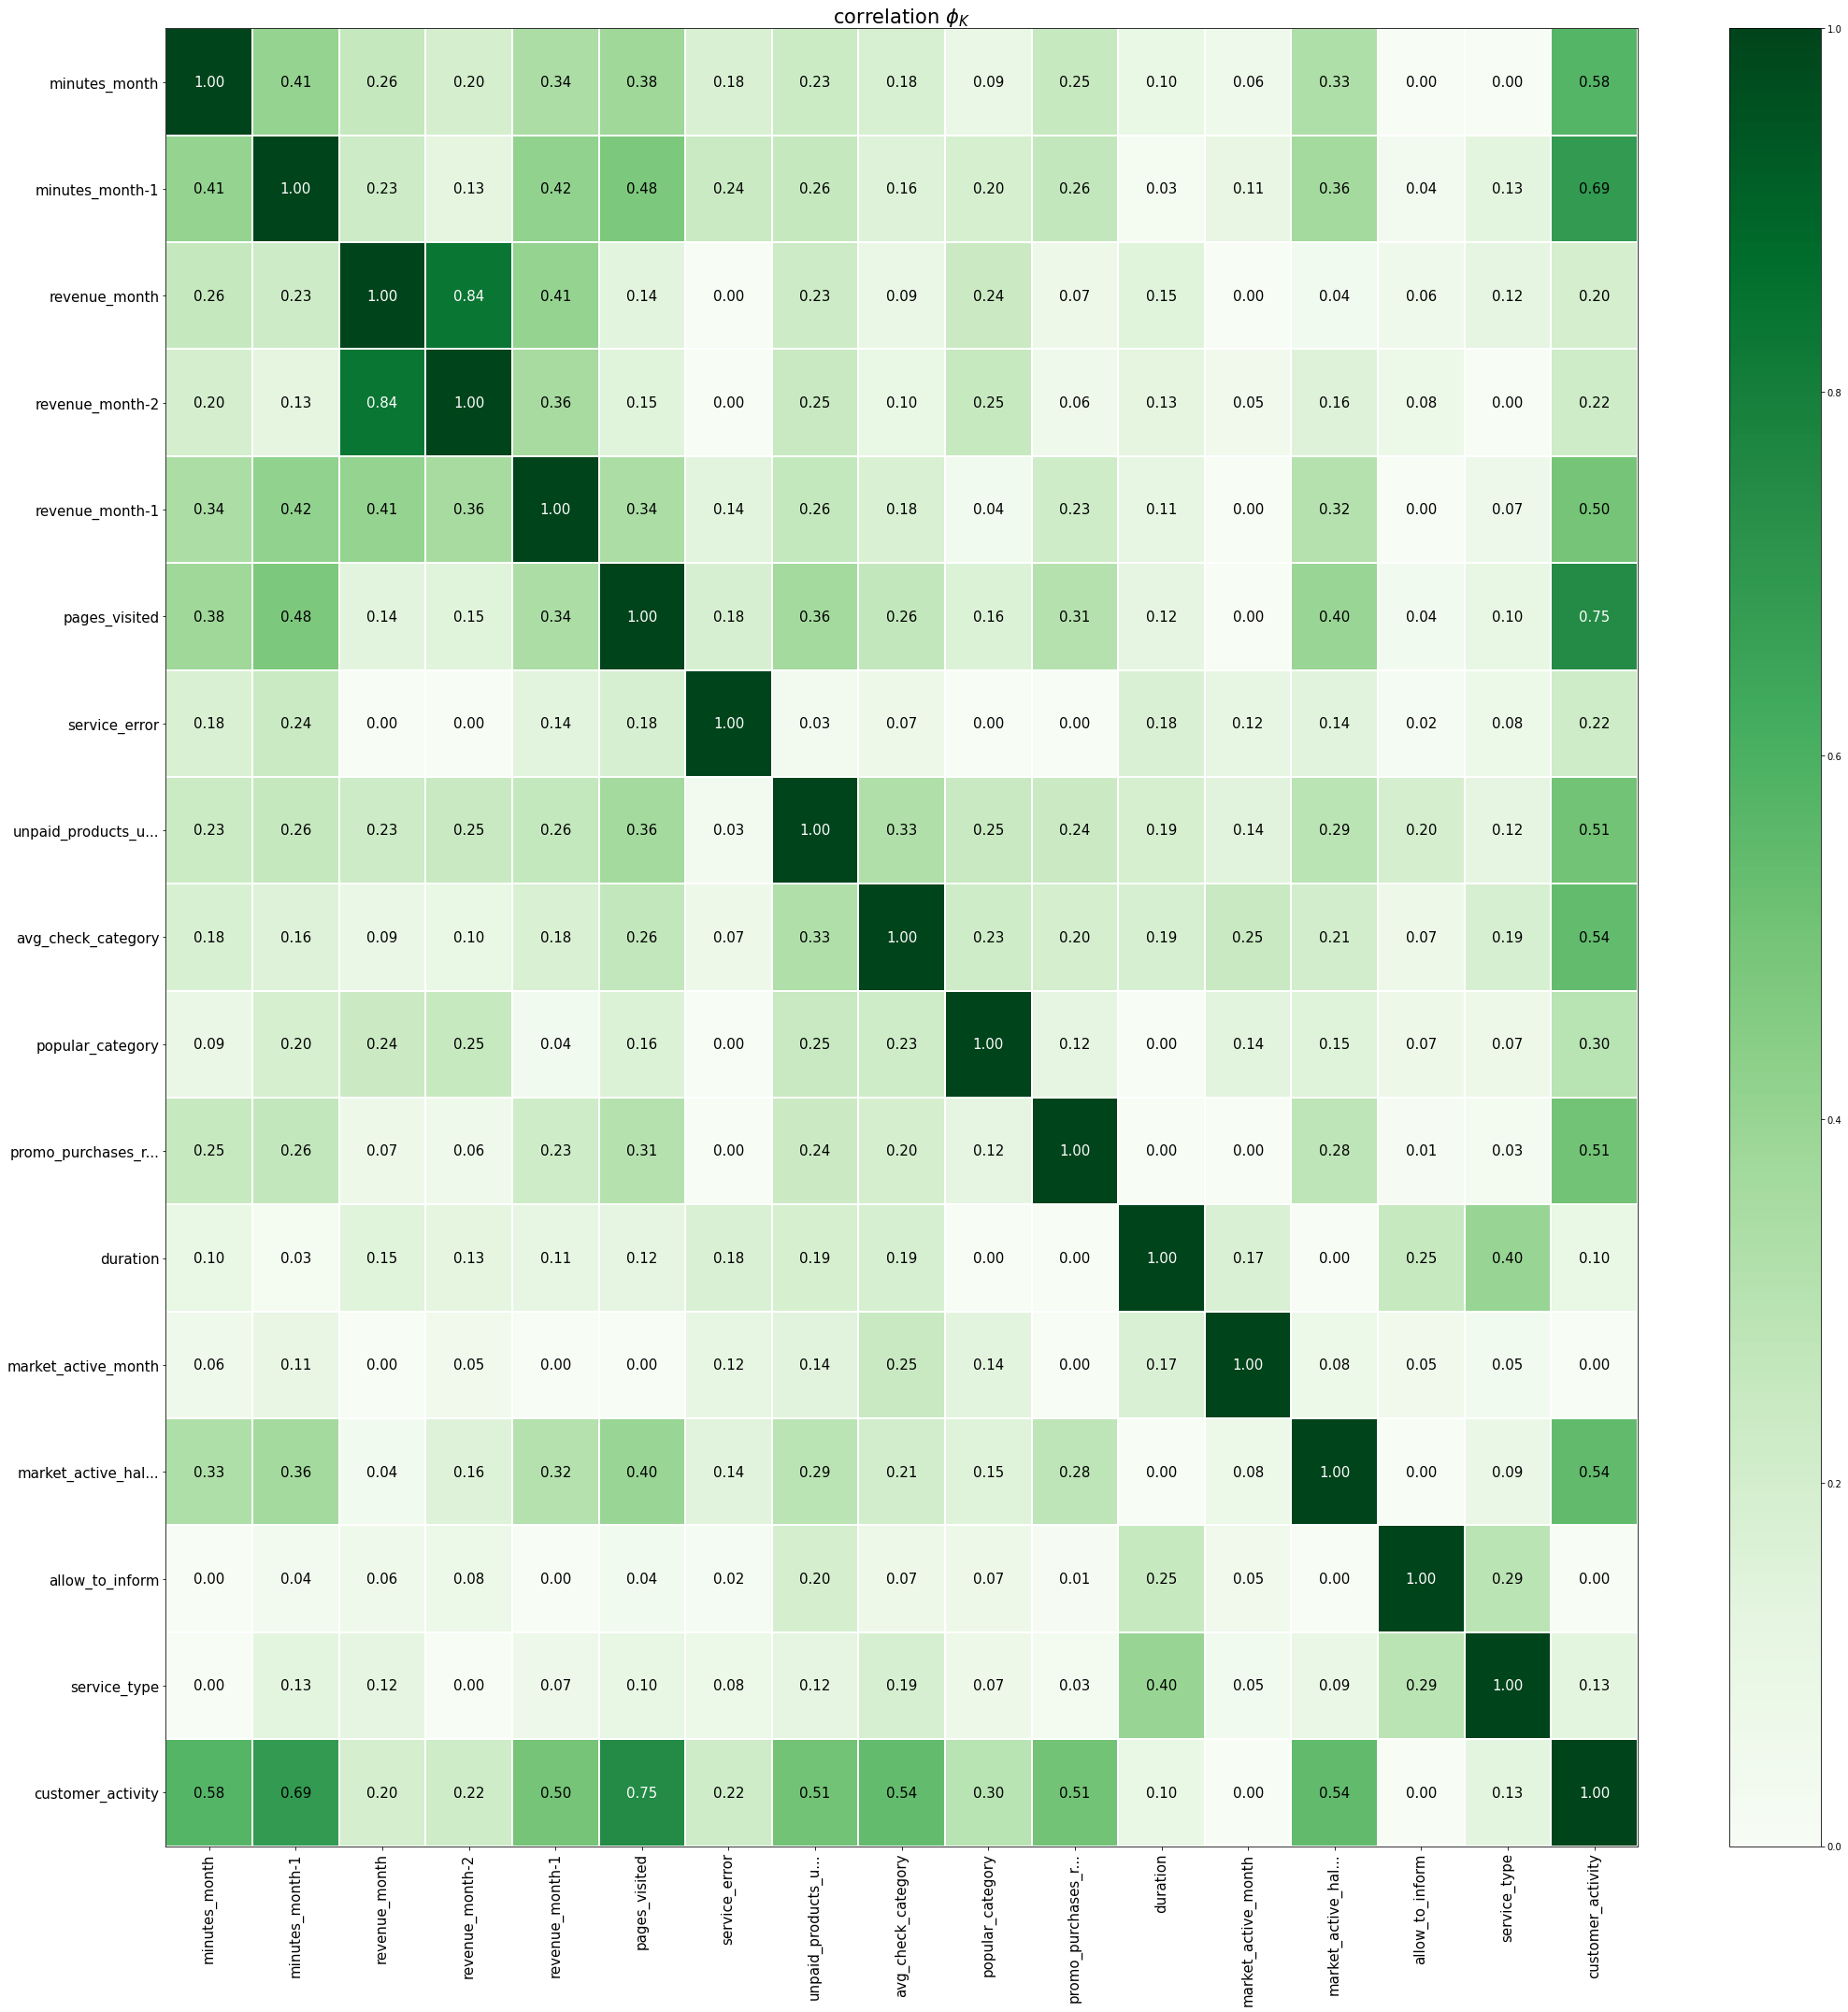

In [88]:
# график тепловой карты матрицы корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(30, 30)
)

Для интерпретации результатов обратимся к `шкале Чеддока`:

Связь|Значение коэффициента корреляции
---|---
слабая|0.1-0.3
умеренная|0.3-0.5
заметная|0.5-0.7
высокая|0.7-0.9
весьма высокая|0.9-1.0

Результаты говорят о наличии взаимосвязи между целевым и остальными признаками:
- `высокая` взаимосвязь с признаком `Кол-во страниц за визит`;
- `заметная` взаимосвязь с признаками `Время за текущий месяц, мин.`, `Время за предыдущий месяц, мин.`, `Неоплаченные продукты, шт./квартал`, `Среднее кол-во просмотров категорий за визит`, `Доля акционных покупок`, `Маркет. актив-ть за 6 месяцев`;
С остальными признаками целевой взаимосвязан умеренно или слабо, кроме признаков `Маркет. актив-ть в текущем месяце` и `Разрешить сообщать` -- с ними взаимосвязь отсутствует. Утечки данных не наблюдается.

Связи входных признаков между собой:
- `высокая`:
    - `Выручка за текущий месяц`, `Выручка за предыдущий месяц` и `Выручка за предпредыдущий месяц`4
    - `Выручка за предпредыдущий месяц` и `Доля акционных покупок`;
- `заметная`:
    - `Выручка за предыдущий месяц` и `Доля акционных покупок`;

Остальные признаки взаимосвязаны умеренно или слабо.

В датасете нет мультиколлинеарных признаков, поскольку значения коэффициентов корреляции не превышают 0.9.

### Итоги корреляционного анализа данных

На текущем шаге произведен корреляционный анализ количественных показателей:
* целевой признак имеет следующие взаимосвязи с входными признаками:
    - `высокая` взаимосвязь с признаком `Кол-во страниц за визит`;
    - `заметная` взаимосвязь с признаками `Время за текущий месяц, мин.`, `Время за предыдущий месяц, мин.`, `Неоплаченные продукты, шт./квартал`, `Среднее кол-во просмотров категорий за визит`, `Доля акционных покупок`, `Маркет. актив-ть за 6 месяцев`;
    - с остальными признаками целевой взаимосвязан умеренно или слабо, кроме признаков `Маркет. актив-ть в текущем месяце` и `Разрешить сообщать` -- с ними взаимосвязь отсутствует;
    -  утечки данных не наблюдается.
* входные признаки имеют следующие взаимосвязи между собой:
    - `высокая`:
        - `Выручка за текущий месяц`, `Выручка за предыдущий месяц` и `Выручка за предпредыдущий месяц`4
        - `Выручка за предпредыдущий месяц` и `Доля акционных покупок`;
    - `заметная`:
        - `Выручка за предыдущий месяц` и `Доля акционных покупок`;
    - остальные признаки взаимосвязанны умеренно или слабо.
* корреляционная матрица показала, что между некоторыми входными признаками есть корреляция, но нет явных признаков наличия мультиколлинеарности, поскольку коэффициенты корреляции не превышают значения `0.9`.

## Использование пайплайнов

### Создание пайплайнов

#### Формирование выборок

In [89]:
target_feature = 'customer_activity'

Учитывая результаты исследовательского анализа данных по [целевому признаку](#Анализ-категориальных-признаков-датасета-market_file), по целевому признаку присутствует дисбаланс классов, поэтому учтем это с помощью параметра `stratify` функции `train_test_split`

In [121]:
X_train, X_test, y_train, y_test = train_test_split(
    df_market.drop(target_feature, axis=1),
    df_market[target_feature],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_market[target_feature]
)

Закодируем категориальный признак с помощью `LabelEncoder`

In [122]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

Проверим полученные классы

In [123]:
encoder.classes_

array(['прежний уровень', 'снизилась'], dtype=object)

Проверим размерности полученных выборок

In [124]:
print('Размерность X_train: ', X_train.shape)
print('Размерность y_train: ', y_train.shape)
print('Размерность X_test: ', X_test.shape)
print('Размерность y_test: ', y_test.shape)

Размерность X_train:  (972, 16)
Размерность y_train:  (972,)
Размерность X_test:  (324, 16)
Размерность y_test:  (324,)


#### Формирование пайплайнов для обработки признаков

##### Формирование списков признаков

Получим список категориальных признаков

In [125]:
category_columns = df_market.select_dtypes(exclude='number').columns.tolist()
category_columns

['customer_activity', 'service_type', 'allow_to_inform', 'popular_category']

Удалим целевой признак из списка

In [126]:
category_columns.remove(target_feature)
category_columns

['service_type', 'allow_to_inform', 'popular_category']

Исходя из [исследовательского анализа](#Анализ-категориальных-признаков-датасета-market_file) категориальных признаков, условно ранжировать значения можно только по столбцу `service_type`, поэтому создадим списки с названиями признаков для обработчиков `OneHotEncoder` и `OrdinalEncoder` с учетом этого.

In [127]:
# создаём списки с названиями признаков
ohe_columns = category_columns[1:]
ohe_columns

['allow_to_inform', 'popular_category']

In [128]:
ord_columns = [category_columns[0]]
ord_columns

['service_type']

In [129]:
ohe_columns = category_columns
ohe_columns

['service_type', 'allow_to_inform', 'popular_category']

Получим список количественных признаков

In [130]:
num_columns = df_market.select_dtypes(include='number').columns.tolist()
num_columns

['market_active_half_year',
 'market_active_month',
 'duration',
 'promo_purchases_ratio',
 'avg_check_category',
 'unpaid_products_unit_quater',
 'service_error',
 'pages_visited',
 'revenue_month-1',
 'revenue_month-2',
 'revenue_month',
 'minutes_month-1',
 'minutes_month']

##### Пайплайны для кодирования признаков

Пайплайн для обработчика неранжированных категориальных признаков

In [131]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

Пайплайн для обработчика ранжированных категориальных признаков

In [132]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

##### Пайплайн для подготовки данных

In [133]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Проверим корректность работы препроцессора

In [134]:
X_train_scaled = data_preprocessor.fit_transform(X_train)
X_test_scaled = data_preprocessor.transform(X_test)

In [135]:
train_data = pd.DataFrame(X_train_scaled, columns=data_preprocessor.get_feature_names_out())
test_data = pd.DataFrame(X_test_scaled, columns=data_preprocessor.get_feature_names_out())

In [136]:
train_data.head()

,ohe__service_type_стандарт,ohe__allow_to_inform_нет,ohe__popular_category_косметика и аксесуары,ohe__popular_category_кухонная посуда,ohe__popular_category_мелкая бытовая техника и электроника,ohe__popular_category_техника для красоты и здоровья,ohe__popular_category_товары для детей,ord__service_type,num__market_active_half_year,num__market_active_month,...,num__promo_purchases_ratio,num__avg_check_category,num__unpaid_products_unit_quater,num__service_error,num__pages_visited,num__revenue_month-1,num__revenue_month-2,num__revenue_month,num__minutes_month-1,num__minutes_month
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.228498,-0.034940,...,-0.678649,-0.926450,0.554520,1.446808,1.973431,-1.451803,0.308218,0.921997,1.641373,-1.744172
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.829033,-0.034940,...,-0.354956,0.559539,1.048557,-1.130716,-1.316315,-0.714636,2.067366,-1.724921,-0.647600,-0.064910
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.030104,1.380136,...,-0.597726,1.302533,-0.927589,-0.615212,0.708144,-0.629125,-1.204835,-1.714569,-0.138940,-0.784593
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.328364,-0.034940,...,2.517826,-0.926450,2.036630,0.415798,-0.051028,1.266868,-0.035885,-0.562990,0.115391,1.374458
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.668960,1.380136,...,0.292432,-0.183455,-0.433553,-1.130716,-0.810200,-0.437461,-1.772856,-0.760751,-0.901931,-0.784593


In [137]:
test_data.head()

,ohe__service_type_стандарт,ohe__allow_to_inform_нет,ohe__popular_category_косметика и аксесуары,ohe__popular_category_кухонная посуда,ohe__popular_category_мелкая бытовая техника и электроника,ohe__popular_category_техника для красоты и здоровья,ohe__popular_category_товары для детей,ord__service_type,num__market_active_half_year,num__market_active_month,...,num__promo_purchases_ratio,num__avg_check_category,num__unpaid_products_unit_quater,num__service_error,num__pages_visited,num__revenue_month-1,num__revenue_month-2,num__revenue_month,num__minutes_month-1,num__minutes_month
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.169629,-0.034940,...,-0.678649,2.045527,-0.927589,-0.099707,0.961202,0.214194,-1.405144,-2.320463,0.624051,0.894668
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,-2.866015,-0.034940,...,2.517826,-0.183455,1.542593,-1.646221,-0.557143,-0.540665,-2.013227,-1.271572,-0.647600,-1.024488
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.968558,-0.034940,...,-0.759573,0.559539,-0.433553,1.962313,0.455087,-0.808993,0.699537,1.304666,1.641373,-0.544699
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.768826,-1.450017,...,0.130585,0.559539,0.060484,0.415798,-0.557143,0.453036,2.359246,1.807872,-1.156261,-1.024488
4,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.228498,-0.034940,...,2.720134,-1.669444,-0.433553,-0.615212,-0.304085,-1.145141,0.193040,0.635946,0.369721,1.134563


##### Итоговый пайплайн

In [138]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

### Подбор модели

#### Подбор гиперпараметров

Создадим список словарей для гиперпараметров 4-х моделей: `DecisionTreeClassifier`, `KNeighborsClassifier`, `LogisticRegression` и `SVC`.

In [139]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],  
        'models__kernel': ['linear', 'rbf']
    }
]

#### Поиск лучшей модели

При выборе метрики для оценки работы модели будем ориентироваться на следующую таблицу:

Метрика|Когда использовать
---|---
Accuracy|Когда данные хорошо сбалансированы, доля объектов каждого класса примерно равна доле остальных.
Recall|Когда необходимо не пропускать объекты класса 1.
Precision|Когда необходимо присваивать класс 1 без ошибок.
F1-score|Когда необходимо при оценке модели учитывать как recall, так и precision. Метрики можно учесть в равной степени или отдать приоритет одной из них.
ROC-AUC|Когда необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности. Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими.

Итак, accuracy не подходит, поскольку присутствует дисбаланс классов. Recall, precision и f1-score требуют работы с порогом классификации, к тому же по заданию нет четкого требования в необходимости отдавать предпочтение одному из классов. Поэтому в данном случае метрика ROC-AUC подходит лучше всего: нет необходимости подбирать порог вероятности и можно использовать в случае, когда присутствует дисбаланс классов.



Для реализации быстрого поиска модели воспользуемся методом `RandomizedSearchCV`

In [140]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['service_type',
                                                                                'allow_to_inform',
                                                                                'popular_category']),
                                                                              ('ord',
                                                                               Pipeli...
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True)],
                                         'models__kernel': ['linear', 'rbf'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [141]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['service_type',
                                                   'allow_to_inform',
                                                   'popular_category']),
                                     

In [142]:
y_test_pred = randomized_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.9204182340330865


По полученным результатам лучшей моделью оказалась модель `KNN` с параметром `k=24`. При этом метрика на тестовой выборке оказалась даже выше, чем на тренировочной, значит отсутствуют какие-то предпосылки к выявлению переобучения или недообучения модели.  

### Итоги использования пайплайнов

На текущем шаге выполнены следующие задачи: 
- [сформированы](#Формирование-выборок) обучающая и тестовая выборки, при формировании была использована стратификация, чтобы минимизировать влияние дисбаланса классов;
- сформированы пайплайны для предобработки данных:
    - [отобраны признаки](#Формирование-списков-признаков) для кодирования разными кодировщиками, для признака `Тип сервиса` использован кодировщик с ранжированием, для остальных `OneHotEncoder`;
    - для обоих вариантов кодировщиков созданы отдельные [пайплайны](#Пайплайн-для-кодирования-признаков);
    - сформирован общий [пайплайн](#Пайплайн-для-подготовки-данных) для подготовки данных;
    - сформирован итоговый [пайплайн](#Итоговый-пайплайн) для работы с моделью;
- реализовано обучение 4-х моделей и выбор лучшей:
    - сформирован список словарей для подбора [гиперпараметров](#Подбор-гиперпараметров);
    - выбрана метрика `ROC-AUC` для оценки моделей;
    - с помощью метода `RandomizedSearchCV` подобрана [лучшая модель](#Поиск-лучшей-модели):
        - модель `KNN` с параметром `k=24`;
        - метрика на тренировочной выборке составила `0.909`
        - метрика на тестовой выборке составила `0.920`

## Анализ важности признаков

### Анализ важности с помощью SHAP

В предыдущем разделе была определена лучшая модель, получим ее из пайплайна 

In [143]:
 model = randomized_search.best_estimator_.named_steps['models']

Также получим из пайплайна предобработчик, с помощью которого произведем преобразование выборок

In [144]:
# получим препроцессор лучшей модели и выборки после обработки
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
X_train_scaled = preprocessor.transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

Сформируем датафреймы для соотнесения колонок с наименованиями признаков

In [145]:
train_data = pd.DataFrame(X_train_scaled, columns=preprocessor.get_feature_names_out())
test_data = pd.DataFrame(X_test_scaled, columns=preprocessor.get_feature_names_out())

Поскольку время расчетов на полной выборке составляет около `18.5 минут`, cформируем семпл из 10-ти наблюдений (анализ и результаты полного расчета будут представлены ниже) для демонстрации работоспособности.

In [146]:
COUNT = 10
# выборка данных для KernelExplainer (чтобы считалось не вечность)
train_data_smpl = shap.sample(train_data, COUNT, random_state=RANDOM_STATE)
test_data_smpl = shap.sample(test_data, COUNT, random_state=RANDOM_STATE)

In [147]:
# используем KernelExplainer, т.к. лучшая модель KNN
explainer = shap.KernelExplainer(model.predict_proba, train_data_smpl)
shap_values = explainer(train_data_smpl)

  0%|          | 0/10 [00:00<?, ?it/s]

In [148]:
shap_values.feature_names = train_data.columns.to_list()

Выведем диаграмму распределения значимости признаков для `10` наблюдений

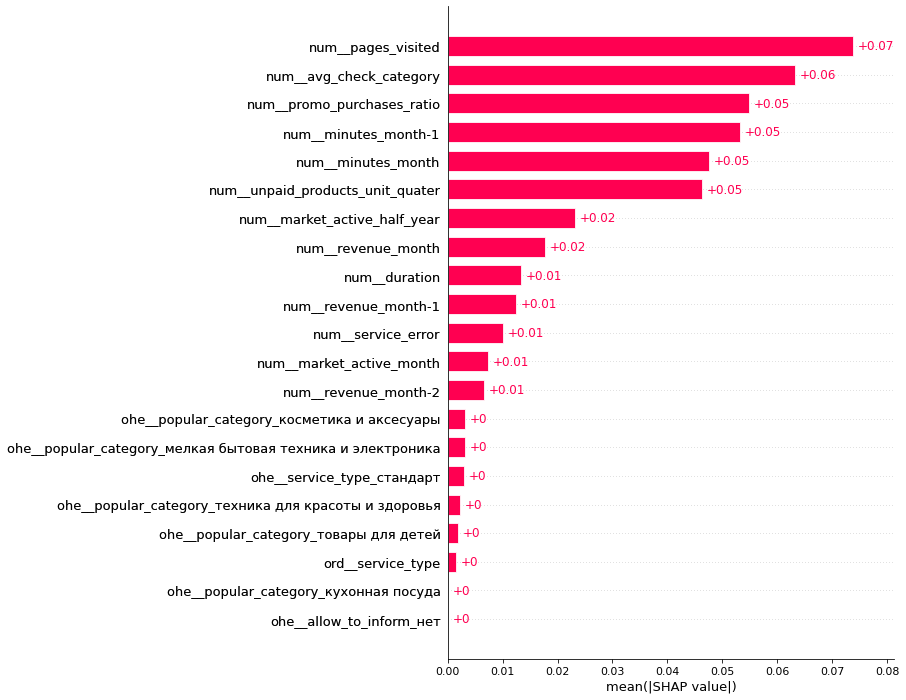

In [149]:
shap.plots.bar(shap_values[:,:,1], max_display=21)

Диаграмма вклада признаков в каждое предсказание модели. На графике точками отображены `10` наблюдений из выборки.

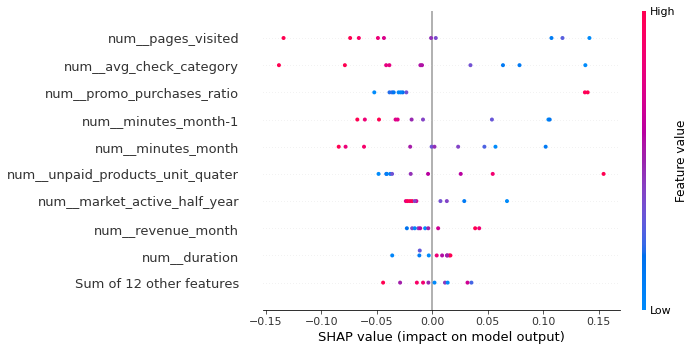

In [150]:
shap.plots.beeswarm(shap_values[:,:,1])

Расчет на полной выборке закомментирован, но результаты в виде графиков сохранены в текстовых ячейках

In [151]:
# используем KernelExplainer, т.к. лучшая модель KNN
#explainer_full = shap.KernelExplainer(model.predict_proba, train_data)
#shap_values_full = explainer(train_data)

In [152]:
#shap_values_full.feature_names = train_data.columns.to_list()

In [153]:
#shap.plots.bar(shap_values_full[:,:,1], max_display=21)

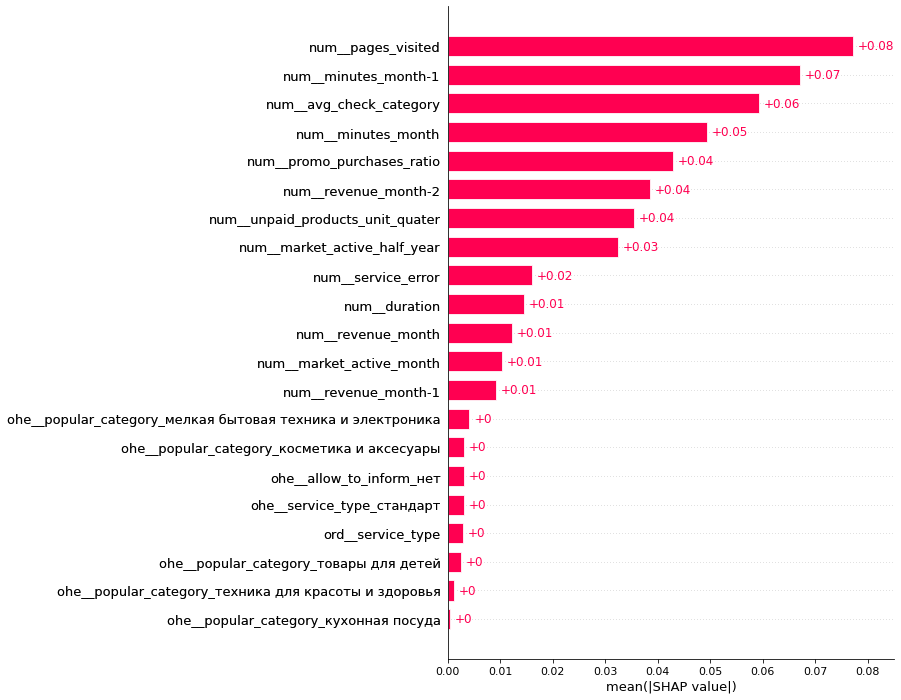

**Наиболее важные признаки при определении активности покупателей**
- `Кол-во страниц за визит`;
- `Время за предыдущий месяц, мин.`;
- `Среднее кол-во просмотров категорий за визит`;
- `Время за текущий месяц, мин.`.

**Наименее важные признаки при определении активности покупателей**
- `Популярная категория`;
- `Тип сервиса`;
- `Разрешить сообщать`.

In [154]:
#shap.plots.beeswarm(shap_values_full[:,:,1])

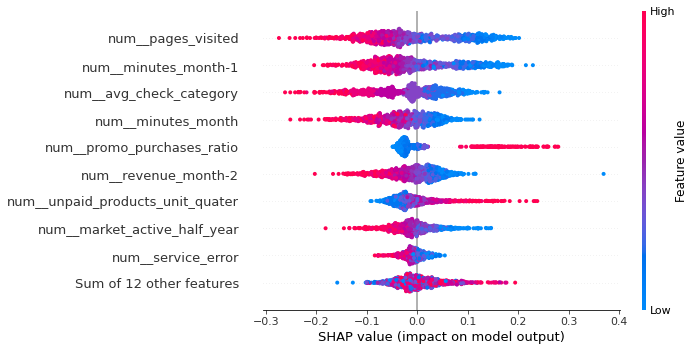

Диаграмма вклада признаков в каждое предсказание модели. На графике точками отображены все наблюдения из выборки. 

Поскольку класс `1` отображает снижение покупательской активности, можно заметить, что на него в основном влияют следующие факторы:
- малое количество просмотренных страниц за визит;
- малое время проведенное на сайте;
- малое количество просмотренных категорий на сайте;
- большая доля акционных товаров;
- большое количество неоплаченных продуктов в корзине;

### Итоги анализа важности признаков

На текущем шаге выполнены следующие задачи:
- с помощью методов библиотеки `shap` осуществлен анализ важности признаков;
- выделены наиболее значимые признаки:
    - `Кол-во страниц за визит`;
    - `Время за предыдущий месяц, мин.`;
    - `Среднее кол-во просмотров категорий за визит`;
    - `Время за текущий месяц, мин.`.
- также определены наименее важные признаки:
    - `Популярная категория`;
    - `Тип сервиса`;
    - `Разрешить сообщать`.
- с помощью диаграммы вклада каждого признака по всем наблюдениям выделены факторы формирования снижения покупательской активности:
    - малое количество просмотренных страниц за визит;
    - малое время проведенное на сайте;
    - малое количество просмотренных категорий на сайте;
    - большая доля акционных товаров;
    - большое количество неоплаченных продуктов в корзине;

## Сегментация покупателей

### Выбор сегмента

В качестве сегмента для анализа выберем группу клиентов с высокой вероятностью снижения покупательской активности и рассмотрим их в разрезе типов сервиса.

Используем лучшую модель, определенную на предыдущем этапе.

Зададим высокий порог вероятности `0.85`

In [155]:
threshold = 0.85

df = df_market.drop(target_feature, axis=1)

df_scaled = preprocessor.transform(df)

predictions = model.predict_proba(df_scaled)[:, 1]
prediction_flags = np.where(predictions > threshold, True, False)

Сформируем датафрейм по покупателям из тестовой выборки, для которых модель предсказала снижение покупательской активности при заданном пороге

In [156]:
df_lower = df.loc[prediction_flags]
df_lower.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 215349 to 216115
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   service_type                 267 non-null    object 
 1   allow_to_inform              267 non-null    object 
 2   market_active_half_year      267 non-null    float64
 3   market_active_month          267 non-null    int64  
 4   duration                     267 non-null    int64  
 5   promo_purchases_ratio        267 non-null    float64
 6   popular_category             267 non-null    object 
 7   avg_check_category           267 non-null    int64  
 8   unpaid_products_unit_quater  267 non-null    int64  
 9   service_error                267 non-null    int64  
 10  pages_visited                267 non-null    int64  
 11  revenue_month-1              267 non-null    float64
 12  revenue_month-2              267 non-null    float64
 13  revenue_mont

`276` покупателей.

Добавим данные о прибыльности от таких покупателей

In [157]:
df_lower = df_lower.merge(df_money, on='id', how='inner')
df_lower.head()

,service_type,allow_to_inform,market_active_half_year,market_active_month,duration,promo_purchases_ratio,popular_category,avg_check_category,unpaid_products_unit_quater,service_error,pages_visited,revenue_month-1,revenue_month-2,revenue_month,minutes_month-1,minutes_month,profit
id,,,,,,,,,,,,,,,,,
215349,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,4.16
215352,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,4.21
215356,стандарт,да,4.2,4,192,0.14,косметика и аксесуары,2,2,1,3,4433.0,4146.5,4566.4,6,7,4.93
215364,премиум,да,4.3,4,708,0.98,домашний текстиль,3,3,3,3,4942.0,5795.5,5484.8,11,9,2.67
215367,премиум,да,4.2,4,581,0.40,товары для детей,5,1,4,1,4668.0,5164.5,5493.4,8,7,3.03


### Графики распределения

Построим графики распределения данных для признаков, формирующих продуктовое поведение и поведение на сайте покупателей с разными категориями сервиса.

In [158]:
num_columns_lower = [
    'minutes_month', 
    'minutes_month-1', 
    'pages_visited',
    'avg_check_category',
    'unpaid_products_unit_quater',
    'popular_category'
]

In [159]:
import math
def plot_hist(df, hue_label, num_columns):
    # количество строк определяется из числа столбцов
    count_rows = math.ceil(len(num_columns) / 2)
    plt.figure(figsize=(15, 5 * count_rows))

    # построение гистограмм для каждого числового столбца
    for i, column in enumerate(num_columns):
        plt.subplot(count_rows, 2, i + 1)
        sns.histplot(data=df, x=column, bins=20, hue=hue_label)
        plt.title(column_translate[column], fontsize=12)
        plt.ylabel("количество", fontsize=10)
        if(column == 'popular_category'):
            plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

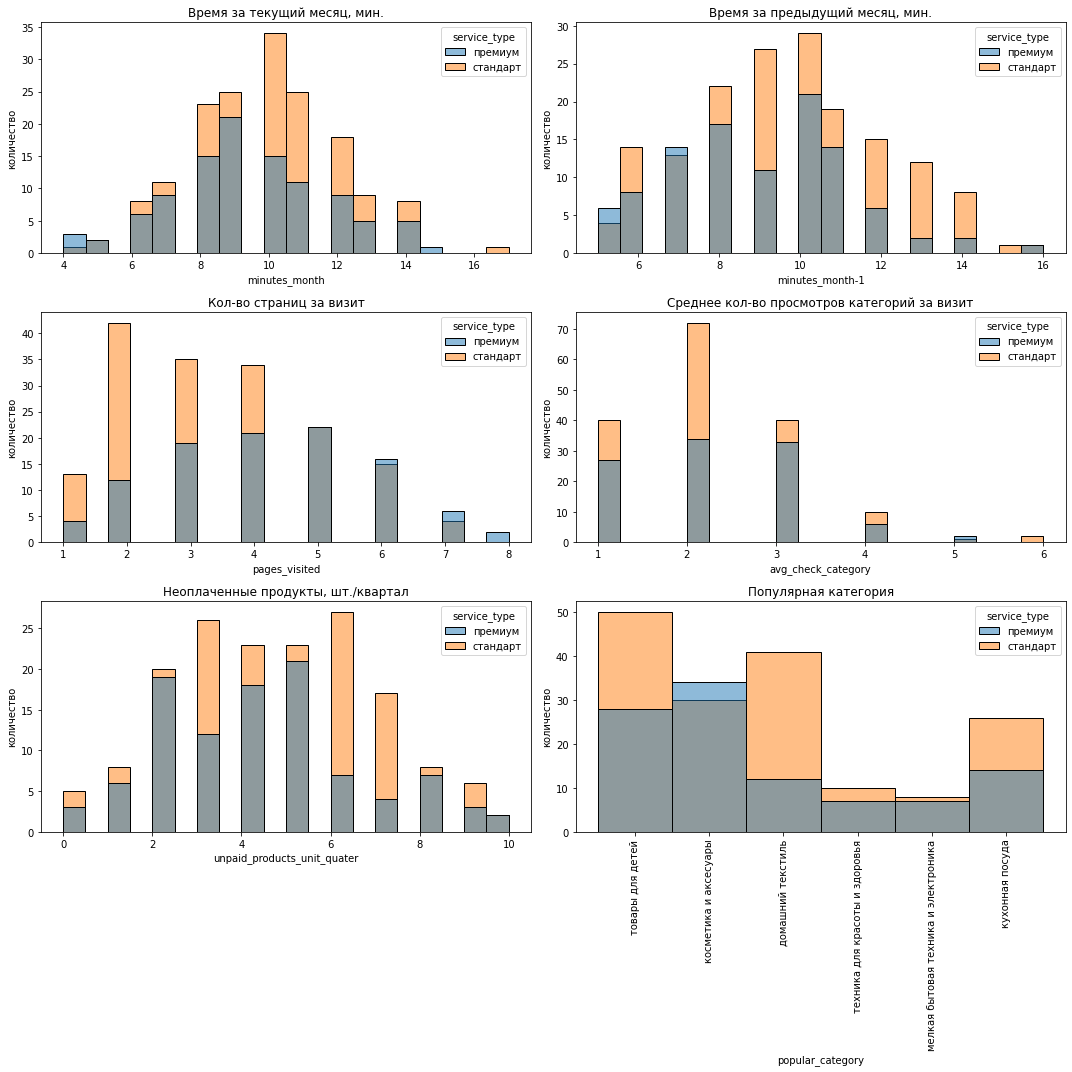

In [160]:
plot_hist(df_lower, 'service_type', num_columns_lower)

При анализе результатов будем учитывать, что покупателей с типом сервиса категории `премиум` представлено меньше в датасете.

Рассмотрим признаки поведения на сайте покупателей обеих категорий сервиса.
- `Время за текущий месяц, мин.`
    - покупатели с типом сервиса `премиум` в текущем месяце чаще проводили на сайте от 8 до 10-ти минут;
    - покупатели с типом сервиса `стандарт` в текущем месяце чаще проводили на сайте от 9 до 11-ти минут;
- `Время за предыдущий месяц, мин.`
    - покупатели с типом сервиса `премиум` в предыдущем месяце чаще проводили на сайте около 10-ти минут;
    - покупатели с типом сервиса `стандарт` в текущем месяце чаще проводили на сайте около 10-ти минут;
- `Кол-во страниц за визит`
    - покупатели с типом сервиса `премиум` чаще просматривали от 3 до 5-х страниц;
    - покупатели с типом сервиса `стандарт` чаще просматривали от 2 до 4-х страниц;
    
Рассмотрим признаки продуктового поведения покупателей обеих категорий сервиса.

- `Среднее кол-во просмотров категорий за визит`
    - покупатели с типом сервиса `премиум` чаще рассматривают от 1-3 категорий за визит;
    - покупатели с типом сервиса `стандарт` чаще просматривают 2 категории;
- `Неоплаченные продукты, шт./квартал`
    - покупатели с типом сервиса `премиум` чаще оставляют в корзине от 2 до 5-ти позиций;
    - покупатели с типом сервиса `стандарт` чаще оставляют в корзине от 2 до 6-ти позиций;
- `Популярная категория`
    - среди покупателей с типом сервиса `премиум` лидирует категория `косметика и аксессуары`, на втором месте `товары для детей`;
    - покупатели с типом сервиса `стандарт` отдают предпочтение категории `товары для детей`, на втором месте `домашний текстиль`;
    

Поведение на сайте и поведение при совершении покупок у обеих категорий мало чем отличается. Есть небольшое отличие в популярных категориях, но этот признак не был выявлен как значимый при прогнозировании снижения покупательской активности. 

Посмотрим на признаки финансового поведения покупателей

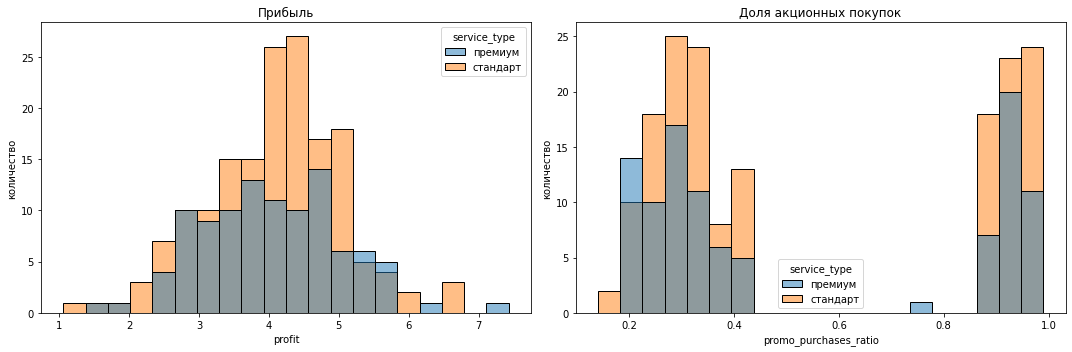

In [161]:
plot_hist(df_lower, 'service_type', ['profit', 'promo_purchases_ratio'])

Распределение среднемесячной прибыли от покупателей за последние 3 месяца для обеих категорий также схоже. Есть сходства и в покупках, совершаемых по акции. 

Возможным вариантом способа увеличения покупательской активности будет предоставление возможности покупателям выбирать раз в месяц любимые категории товаров, которые позволят либо приобрести выделенную группу товаров по акции, либо будут предусматривать какие-то бонусы по программе лояльности (например, баллы). 

Также величина этих скидок/бонусов может быть напрямую связана с типом сервиса покупателей (например, для категории `премиум` эти значения будут выше), что может стимулировать покупателей переходить на более высокий уровень сервиса и в дальнейшем при выборе места покупок отдавать предпочтение этому магазину.

Возможно стоит предусмотреть расширение ассортимента в выявленных популярных категориях товаров. 

### Итоги сегментации покупателей

На текущем шаге выполнены следующие задачи:
- в качестве сегмента для анализа была выбрана группа клиентов с высокой вероятностью снижения покупательской активности с выделением категорий по типам сервиса;
- проанализированы показатели продуктового поведения покупателей и поведения на сайте:
    - у обеих категорий распределение показателей мало чем отличается, за исключением популярных категорий -- покупатели с типом сервиса `стандарт` чаще приобретают товары для детей и дома, тогда как покупатели категории `премиум` чаще приобретают товары личного пользования;
- проанализированы некоторые показатели финансового поведения:
    - для обеих категорий не выявлено существенных различий в распределении полученной прибыли и товаров, приобретаемых по акции.

## Итоговые выводы

**Постановка задачи.** 
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Заказчик** этого проекта:

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования.

**Исходные данные**, предоставляемые для реализации проекта, содержат данные о поведении и времени покупателя на сайте, а также данные о выручке и его продуктовом поведении.

На [первом](#Общая-информация-о-данных) шаге выполнены следующие задачи:
- произведен [импорт](#Импорт-данных) данных из исходных файлов, датасеты сохранены в соответствующие датафреймы; 
- для каждого датафрейма [`df_market_file`](#Датасет-market_file), [`df_market_money`](#Датасет-market_money), [`df_market_time`](#Датасет-market_time), [`df_money`](#Датасет-money) выведены основные характеристики.
- первичный анализ данных по всем датасетам не выявил наличия пропусков и явных полных дубликатов, а также необходимости производить переводы данных в другие типы. 

На [втором](#Предобработка-данных) шаге выполнены следующие задачи: 
- для всех датафремов:
    - не обнаружено пропусков значений в столбцах и полных явных дубликатов;
    - определено, что значения в столбцах соответствуют их типу;
    - произведено переименование столбцов;
- для датафрейма [`df_market_file`](#Предобработка-датасета-df_market_file) также:
    - устранены неявные дубликаты в столбцах с категориальными значениями, значения приведены к единому формату.
- для датафреймов [`df_market_money`](#Предобработка-датасета-df_market_money) и [`df_market_time`](#Предобработка-датасета-df_market_time) также:
    - обнаружены явные дубликаты в столбце `id`, что соответствует наличию данных за несколько месяцев;
    - неявных дубликатов в столбцах с категориальными значениями не обнаружено, значения приведены к единому формату.

На [третьем](#Исследовательский-анализ-данных) шаге выполнены следующие задачи: 
- для всех датафреймов:
    - определены количественные признаки;
    - выведены статистические характеристики и построены графики распределения для всех количественных признаков;
    - определены категориальные признаки;
    - выведены графики распределения количества записей в датасете для всех категориальных признаков.
    
- в датафрейме [`df_market_file`](#Исследовательский-анализ-датасета-df_market_file):
    - большая часть показателей относится к дискретным величинам;
    - большая часть значений распределены близко к нормальному с незначительными либо отсутствующими выбросами;
    - по столбцу `promo_purchases_ratio` распределение близко к бимодальному;
    - выявлен небольшой дисбаланс классов по целевому показателю;
    - самая популярная категория товаров среди покупателей `товары для детей`, доля записей составляет `25.38%`. Меньше всего покупатели отдают предпочтение категории `кухонная посуда`, доля составляет `10.62%`.
      
- в датафрейме [`df_market_money`](#Исследовательский-анализ-датасета-df_market_money):
    - удалена строка с выбивающимся значением, после удаления распределение значений близко к нормальному с незначительными выбросами;
    - данные распределены в равных пропорциях по трем месяцам;
        
- в датафрейме [`df_market_time`](#Исследовательский-анализ-датасета-df_market_time):
    - данные распределены близко к нормальному, выбивающихся значений нет.
    - данные распределены в равных пропорциях по двум месяцам;
        
- в датафрейме [`df_money`](#Исследовательский-анализ-датасета-df_money):
    - данные распределены близко к нормальному, есть незначительная доля выбивающихся значений.
    - категориальные признаки в датасете отсутствуют.

На [четвертом](#Объединение-таблиц) шаге:
- проведено [объединение](#Объединение-датасетов) исходных датасетов в общий датафрейм: после объединения датасетов получили общий датафрейм, состоящий из `17` столбцов и содержащий `1296` строк;
- убраны из рассмотрения пользователи, которые не совершали покупок хотя бы в одном из трех месяцев.
<br></br>

На [пятом](#Корреляционный-анализ) шаге произведен корреляционный анализ количественных показателей:
* целевой признак имеет следующие взаимосвязи с входными признаками:
    - `высокая` взаимосвязь с признаком `Кол-во страниц за визит`;
    - `заметная` взаимосвязь с признаками `Время за текущий месяц, мин.`, `Время за предыдущий месяц, мин.`, `Неоплаченные продукты, шт./квартал`, `Среднее кол-во просмотров категорий за визит`, `Доля акционных покупок`, `Маркет. актив-ть за 6 месяцев`;
    - с остальными признаками целевой взаимосвязан умеренно или слабо, кроме признаков `Маркет. актив-ть в текущем месяце` и `Разрешить сообщать` -- с ними взаимосвязь отсутствует;
    -  утечки данных не наблюдается.
* входные признаки имеют следующие взаимосвязи между собой:
    - `высокая`:
        - `Выручка за текущий месяц`, `Выручка за предыдущий месяц` и `Выручка за предпредыдущий месяц`4
        - `Выручка за предпредыдущий месяц` и `Доля акционных покупок`;
    - `заметная`:
        - `Выручка за предыдущий месяц` и `Доля акционных покупок`;
    - остальные признаки взаимосвязанны умеренно или слабо.
* корреляционная матрица показала, что между некоторыми входными признаками есть корреляция, но нет явных признаков наличия мультиколлинеарности, поскольку коэффициенты корреляции не превышают значения `0.9`.

На [шестом](#Использование-пайплайнов) шаге выполнены следующие задачи: 
- [сформированы](#Формирование-выборок) обучающая и тестовая выборки, при формировании была использована стратификация, чтобы минимизировать влияние дисбаланса классов;
- сформированы пайплайны для предобработки данных:
    - [отобраны признаки](#Формирование-списков-признаков) для кодирования разными кодировщиками, для признака `Тип сервиса` использован кодировщик с ранжированием, для остальных `OneHotEncoder`;
    - для обоих вариантов кодировщиков созданы отдельные [пайплайны](#Пайплайн-для-кодирования-признаков);
    - сформирован общий [пайплайн](#Пайплайн-для-подготовки-данных) для подготовки данных;
    - сформирован итоговый [пайплайн](#Итоговый-пайплайн) для работы с моделью;
- реализовано обучение 4-х моделей и выбор лучшей:
    - сформирован список словарей для подбора [гиперпараметров](#Подбор-гиперпараметров);
    - выбрана метрика `ROC-AUC` для оценки моделей;
    - с помощью метода `RandomizedSearchCV` подобрана [лучшая модель](#Поиск-лучшей-модели):
        - модель `KNN` с параметром `k=24`;
        - метрика на тренировочной выборке составила `0.909`
        - метрика на тестовой выборке составила `0.920`

На [седьмом](#Анализ-важности-признаков) шаге выполнены следующие задачи:
- с помощью методов библиотеки `shap` осуществлен анализ важности признаков;
- выделены наиболее значимые признаки:
    - `Кол-во страниц за визит`;
    - `Время за предыдущий месяц, мин.`;
    - `Среднее кол-во просмотров категорий за визит`;
    - `Время за текущий месяц, мин.`.
- также определены наименее важные признаки:
    - `Популярная категория`;
    - `Тип сервиса`;
    - `Разрешить сообщать`.
- с помощью диаграммы вклада каждого признака по всем наблюдениям выделены факторы формирования снижения покупательской активности:
    - малое количество просмотренных страниц за визит;
    - малое время проведенное на сайте;
    - малое количество просмотренных категорий на сайте;
    - большая доля акционных товаров;
    - большое количество неоплаченных продуктов в корзине;

На [восьмом](#Сегментация-покупателей) шаге выполнены следующие задачи:
- в качестве сегмента для анализа была выбрана группа клиентов с высокой вероятностью снижения покупательской активности с выделением категорий по типам сервиса;
- проанализированы показатели продуктового поведения покупателей и поведения на сайте:
    - у обеих категорий распределение показателей мало чем отличается, за исключением популярных категорий -- покупатели с типом сервиса `стандарт` чаще приобретают товары для детей и дома, тогда как покупатели категории `премиум` чаще приобретают товары личного пользования;
- проанализированы некоторые показатели финансового поведения:
    - для обеих категорий не выявлено существенных различий в распределении полученной прибыли и товаров, приобретаемых по акции.

**Рекомендации**

Возможным вариантом способа увеличения покупательской активности будет предоставление возможности покупателям выбирать раз в месяц любимые категории товаров, которые позволят либо приобрести выделенную группу товаров по акции, либо будут предусматривать какие-то бонусы по программе лояльности (например, баллы). 

Также величина этих скидок/бонусов может быть напрямую связана с типом сервиса покупателей (например, для категории `премиум` эти значения будут выше), что может стимулировать покупателей переходить на более высокий уровень сервиса и в дальнейшем при выборе места покупок отдавать предпочтение этому магазину.

Возможно стоит предусмотреть расширение ассортимента в выявленных популярных категориях товаров. 